# Book Detection with SAM, CLIP, and Google Vision API
#### By Sarthak Dayal, Mukund Raman, and Praneel Seth

Import all required packages:

In [5]:
import io
import os
import csv
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import CLIPProcessor, CLIPModel, TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import itertools

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import torch
import cv2

/home/bwilab/miniconda3/envs/AlbusFRIEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set input parameters for retrieving a book title, sample_text, from a sample image:

In [26]:
image_num = 10
sample_text = "Order"
sample_image = f"images/image{image_num}.png"

Use pre-trained models and processors from CLIP:

In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define helper functions to help with processing the image:

In [8]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Plot the given image
def show_annotated(annotated_image):
    plt.figure(figsize=(20,20))
    plt.imshow(annotated_image)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    plt.axis('off')
    plt.show()

def resize_image(image_path, size=(1024, 1024)):
    # Open the image file
    with open(image_path, 'rb') as image_file:
        image = Image.open(image_file)
        image = image.resize(size)

        # Save the image back to a byte buffer
        byte_arr = io.BytesIO()
        image.save(byte_arr, format='JPEG')
        byte_arr = byte_arr.getvalue()
    return byte_arr

Load and resize the image and then create the mask generator with all of the fine-tuned parameters:

In [9]:
image = load_image(sample_image)
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device="cuda")
image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)

mask_generator = SamAutomaticMaskGenerator(
   model=sam,
   points_per_side=32,
   points_per_batch=128,
   pred_iou_thresh=0.98,
   stability_score_thresh=0.97,
   crop_n_layers=1,
   crop_n_points_downscale_factor=2,
   min_mask_region_area=500
)

Use the mask generator to segment the image into a list of masks (may take a while)

In [10]:
masks = mask_generator.generate(image)

Once that's done, annotate the original images with the segmented masks to highlight which objects were detected:

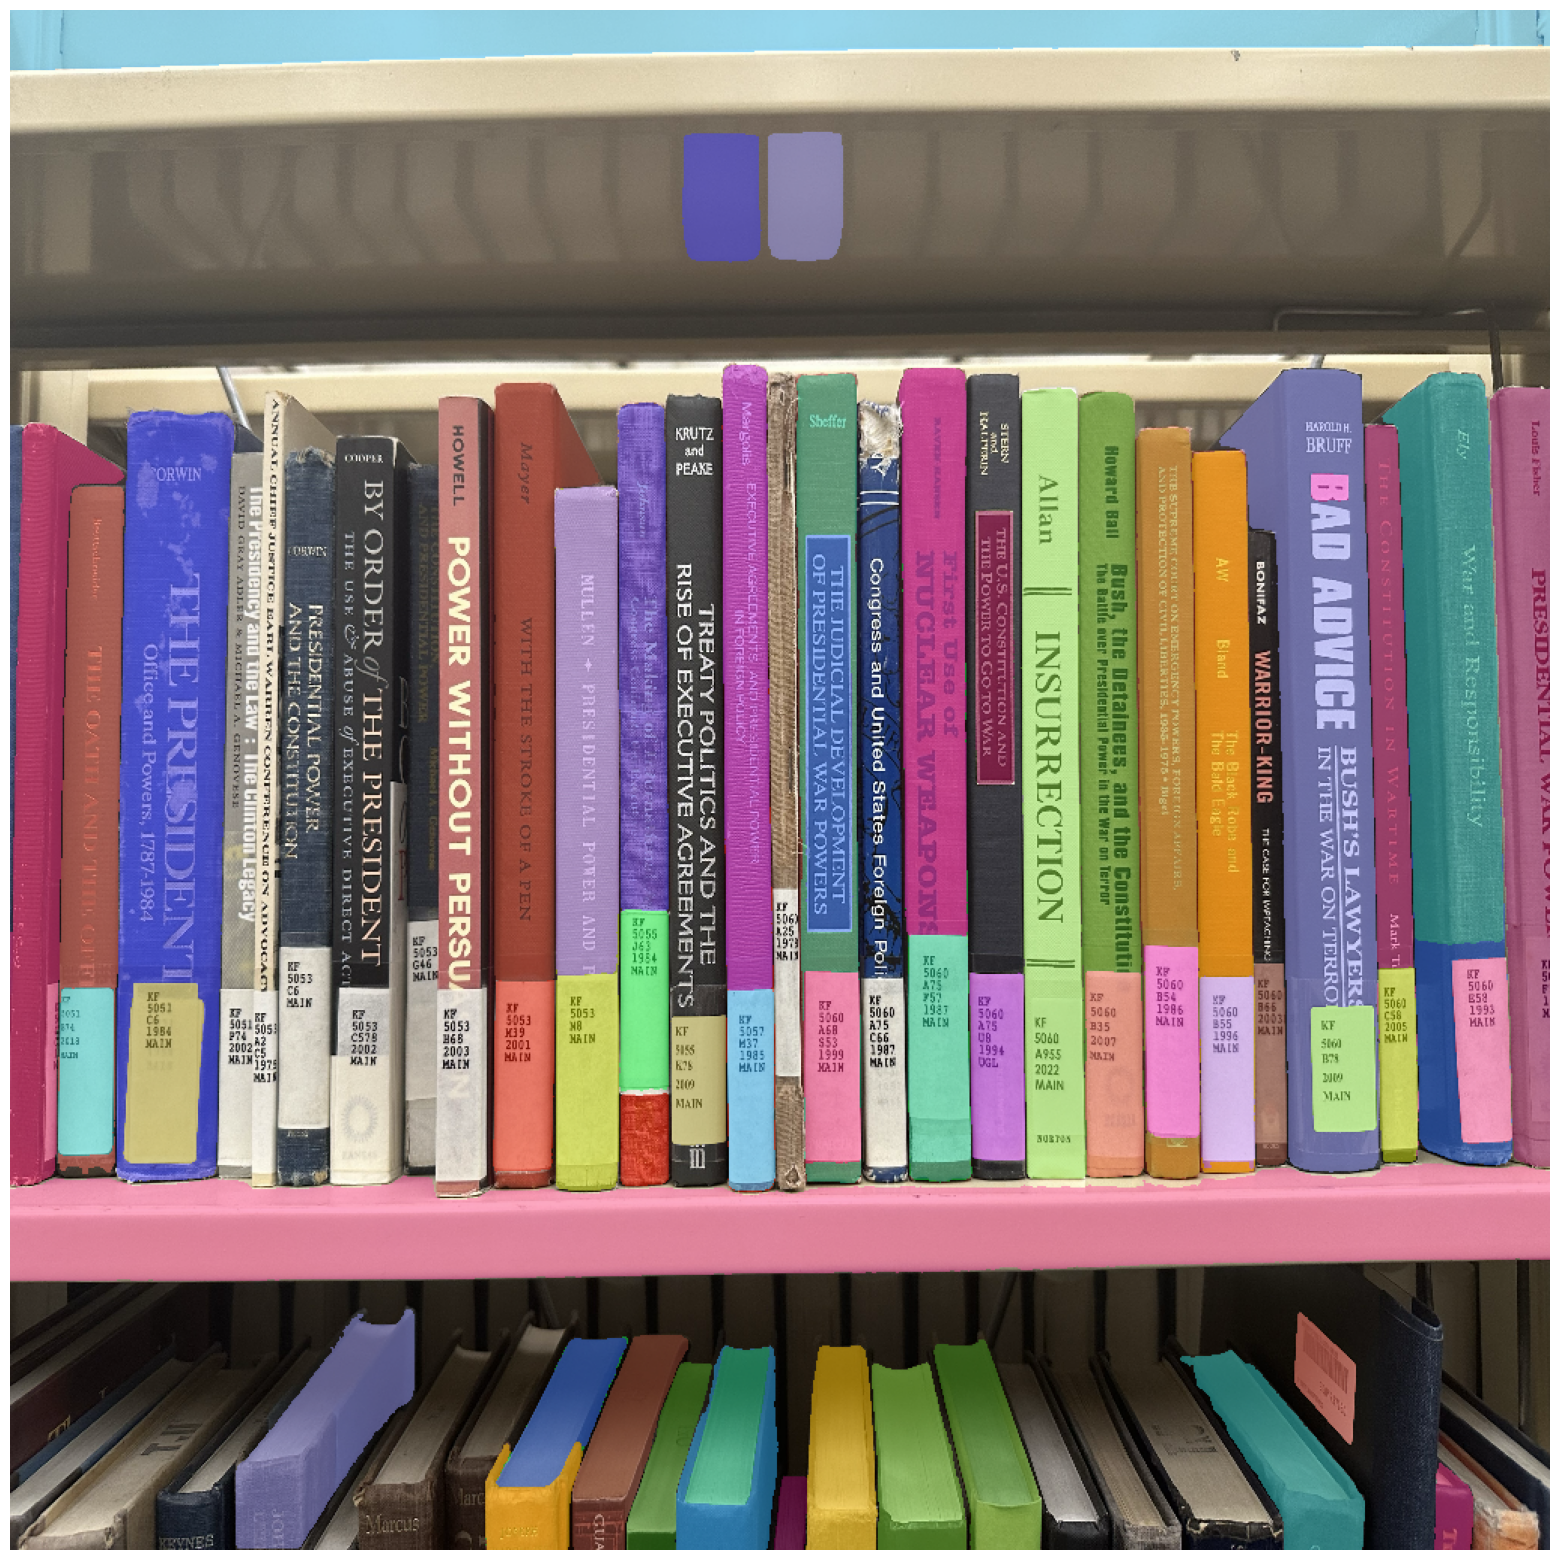

In [11]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(image, detections)
show_annotated(annotated_image)

Use CLIP to classify a given segment mask as a book or not a book:

In [12]:
def classify_mask_as_book(masked_img, labels):
    # Prepare the image for the CLIP model
    pil_image = Image.fromarray(masked_img)
    inputs = processor(text=labels, images=pil_image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    # Get the predicted label
    logits_per_image = outputs.logits_per_image
    probs = torch.softmax(logits_per_image, dim=1)
    best_label_idx = torch.argmax(probs)
    return labels[best_label_idx] == "red book" or labels[best_label_idx] == "text on book spine" or labels[best_label_idx] == "tilted book"

Load in the labels from a CSV file for the CLIP Model:

In [13]:
# Open the CSV file
with open('labels.csv', 'r') as f:
    # Create a CSV reader object
    reader = csv.reader(f)

    # Read the CSV file line by line
    labels = []
    for row in reader:
        # Add each row to the data list
        for item in row:
            labels.append(item)
print(labels)

['text on book spine', 'red book', 'tilted book', 'white book with black text', 'something else', 'wall']


Iterate through all of the mask segments and filter out non-book segments:

In [14]:
book_segments = []
for i, mask_dict in enumerate(masks):
    # Retrieve the masked image by applying the mask to the original image
    mask = np.repeat(mask_dict['segmentation'][:, :, np.newaxis].astype(np.uint8), 3, axis=2) * 255
    masked_img = image.copy()
    cv2.bitwise_and(image.astype(np.uint8), mask, masked_img)

    # Classify segment as book/non-book
    if classify_mask_as_book(masked_img, labels):
        # Get the coordinates covered by the mask
        coords = np.where(mask != 0)
        y_coords = coords[0]
        x_coords = coords[1]
        
        # Add the segment to the list of book segments
        book_segments.append({
            "masked_img": masked_img,
            "coords": list(zip(x_coords, y_coords))
        })
        print(f"Segment {i} is a book")
        print(f"Coordinates covered by Segment {i}: {list(zip(x_coords, y_coords))[:10]}")
    else:
        print(f"Segment {i} is not a book")

Segment 0 is not a book
Segment 1 is not a book
Segment 2 is not a book
Segment 3 is not a book
Segment 4 is not a book
Segment 5 is not a book
Segment 6 is not a book
Segment 7 is not a book
Segment 8 is not a book
Segment 9 is not a book
Segment 10 is not a book
Segment 11 is not a book
Segment 12 is not a book
Segment 13 is not a book
Segment 14 is not a book
Segment 15 is not a book
Segment 16 is not a book
Segment 17 is not a book
Segment 18 is not a book
Segment 19 is not a book
Segment 20 is not a book
Segment 21 is not a book
Segment 22 is not a book
Segment 23 is not a book
Segment 24 is not a book
Segment 25 is not a book
Segment 26 is not a book
Segment 27 is not a book
Segment 28 is a book
Coordinates covered by Segment 28: [(380, 317), (380, 317), (380, 317), (381, 317), (381, 317), (381, 317), (382, 317), (382, 317), (382, 317), (383, 317)]
Segment 29 is not a book
Segment 30 is a book
Coordinates covered by Segment 30: [(644, 333), (644, 333), (644, 333), (645, 333), (64

Display the book segments:

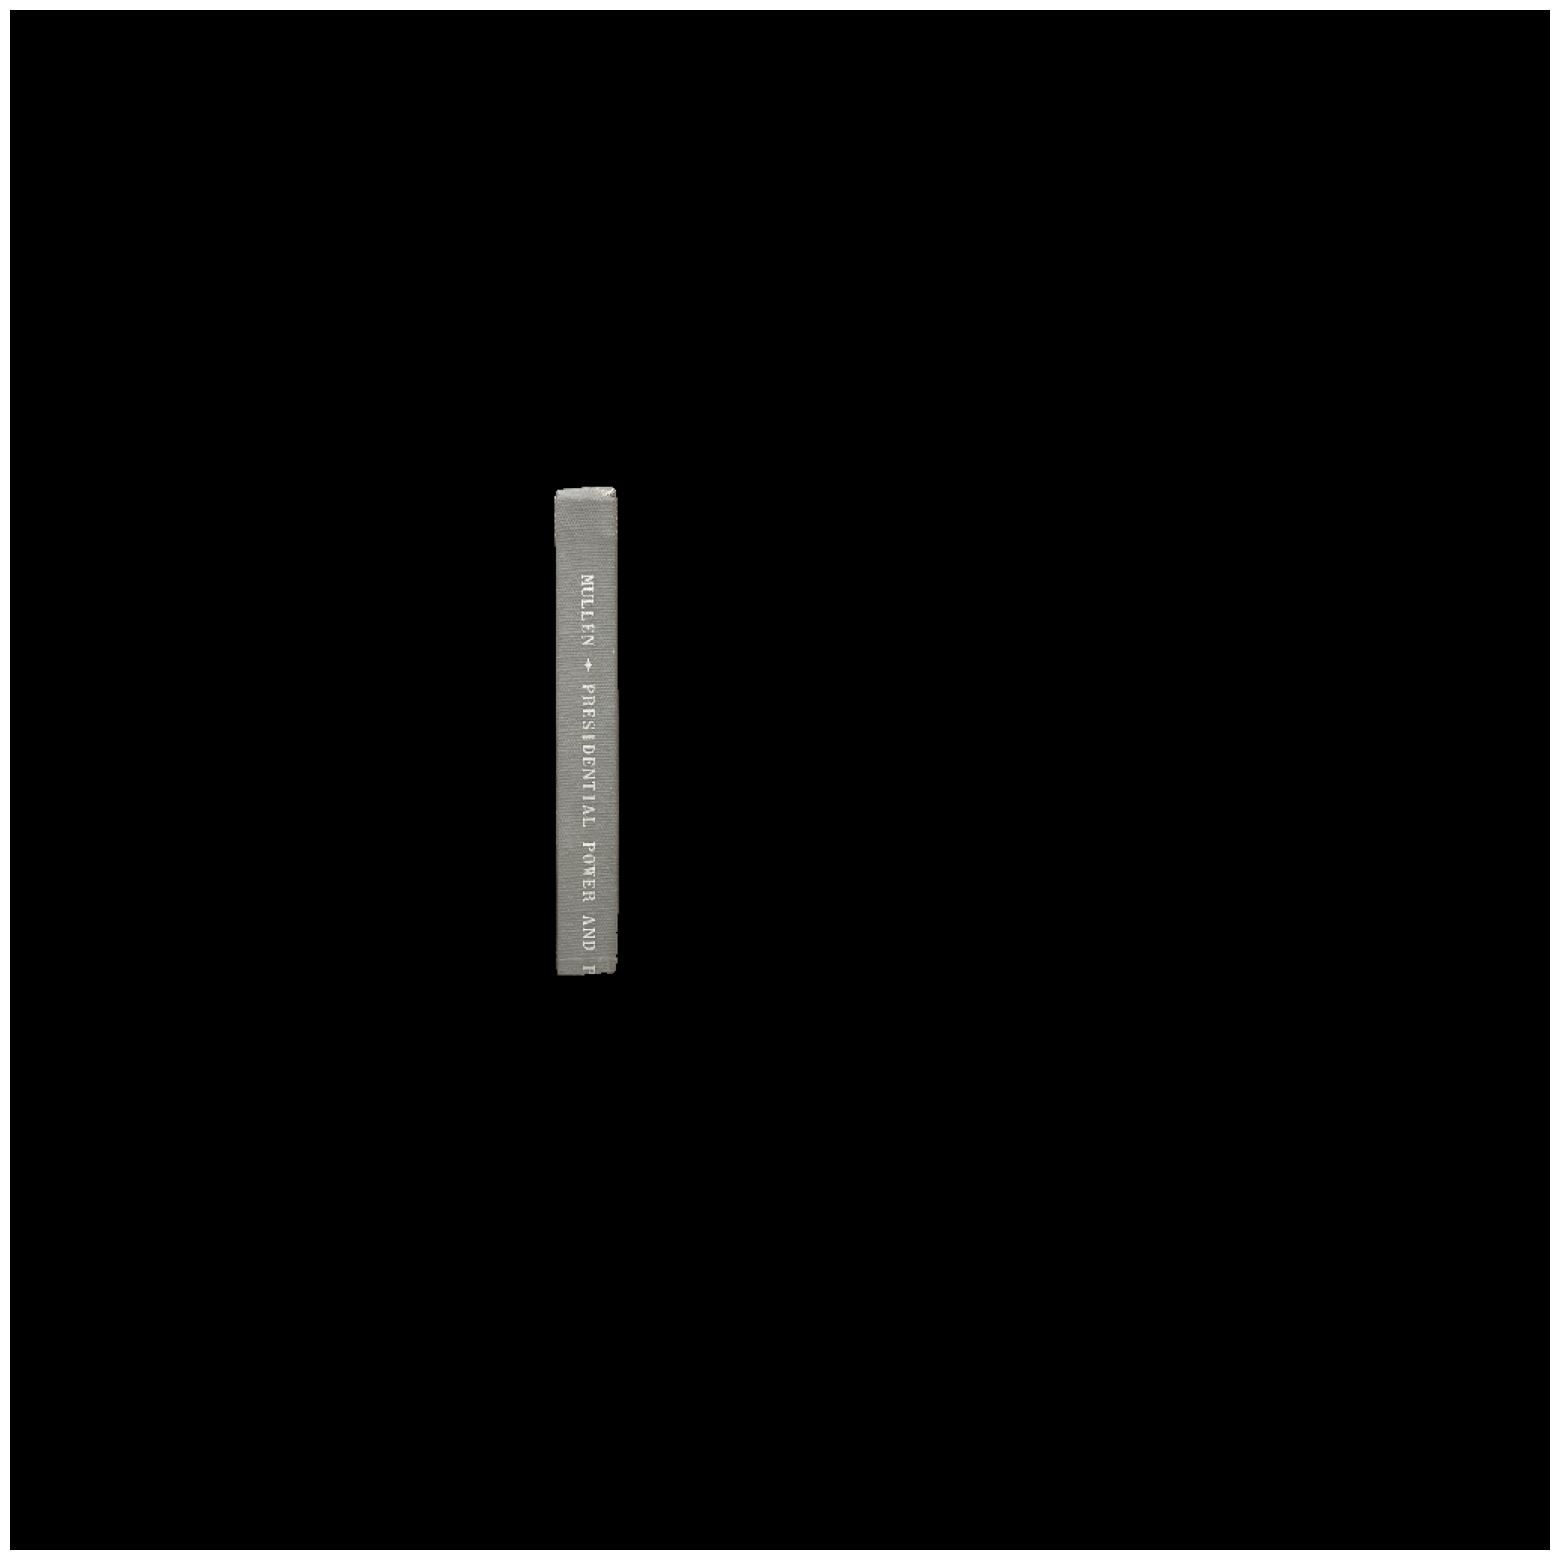

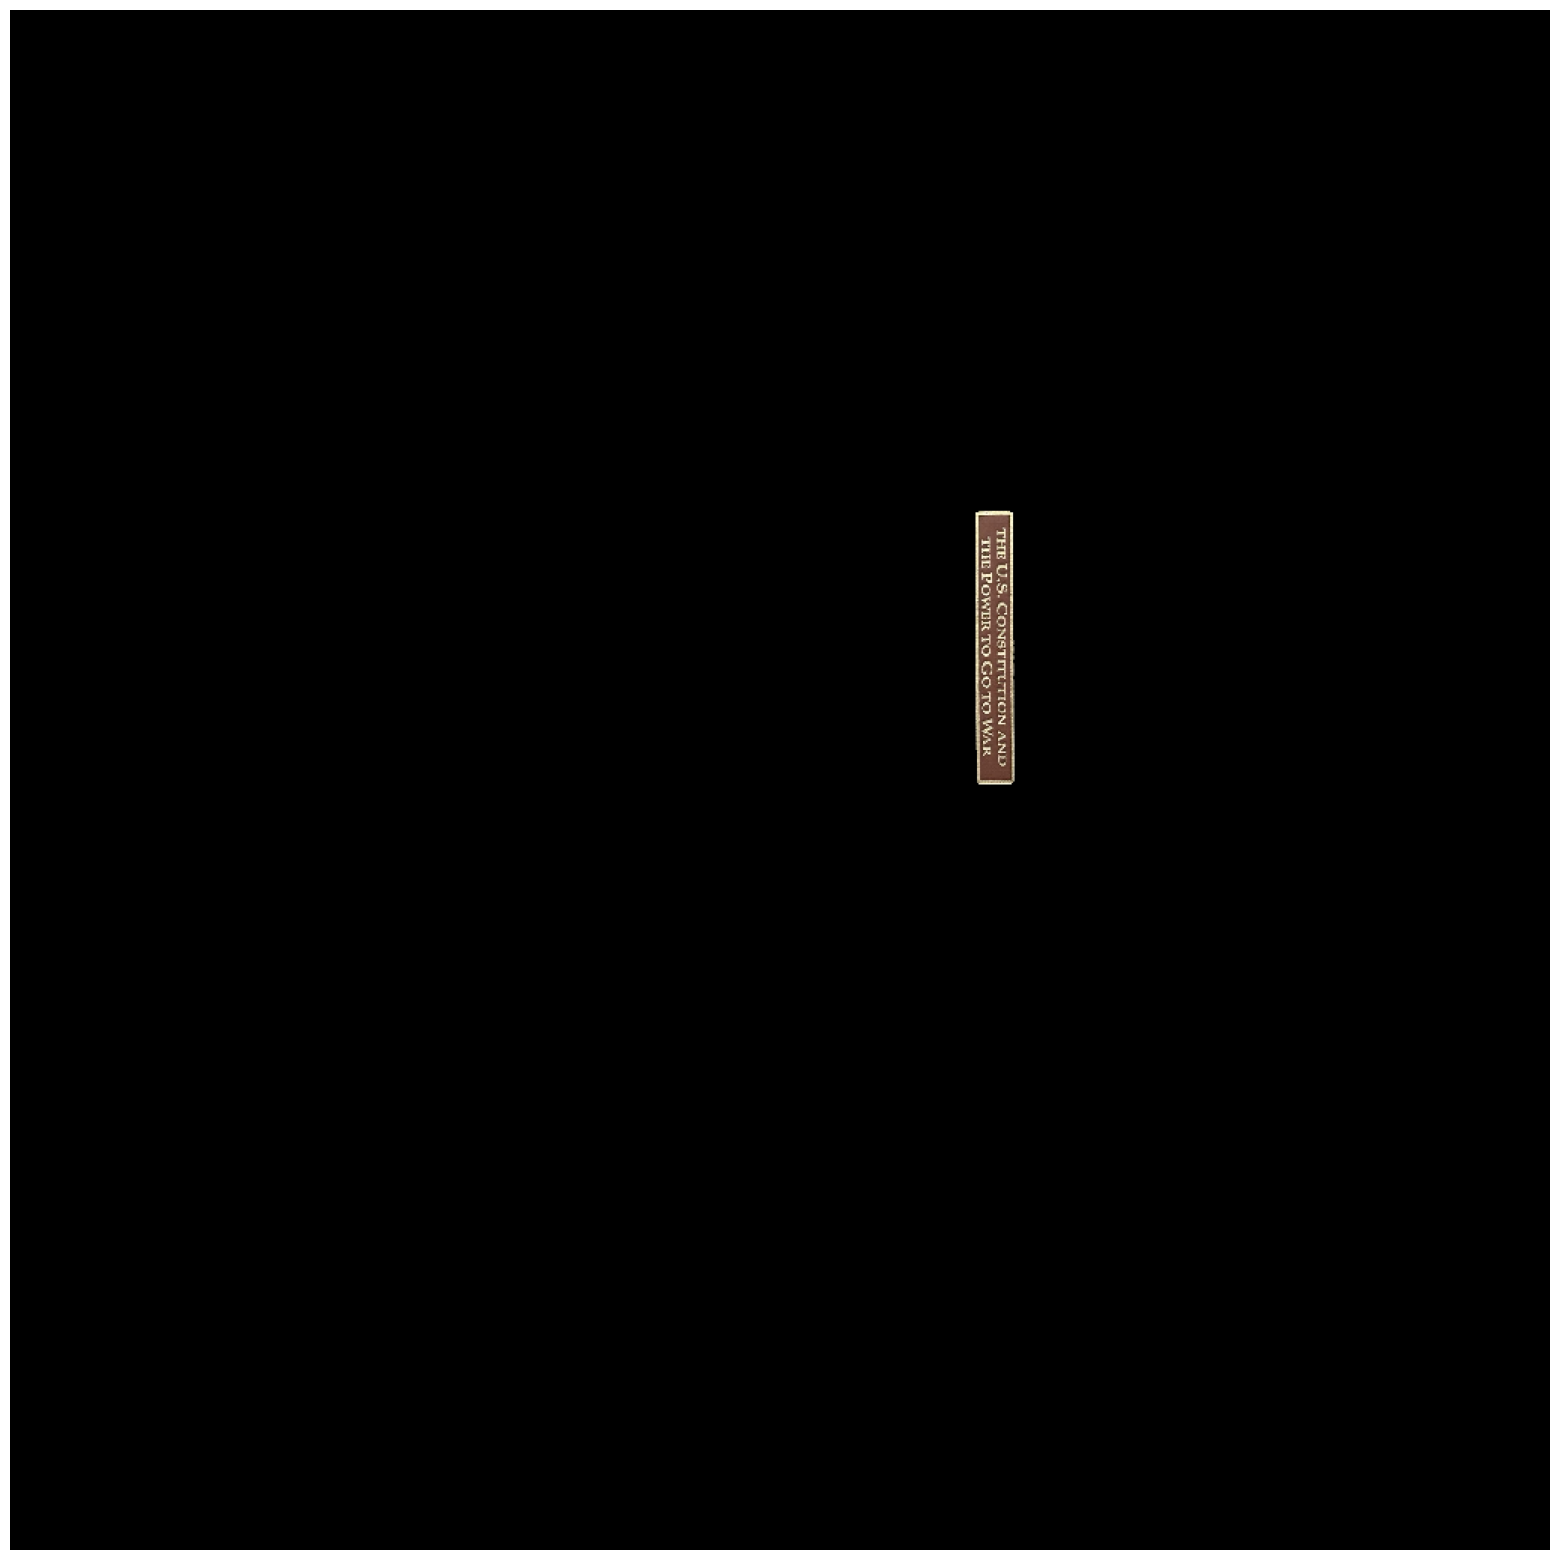

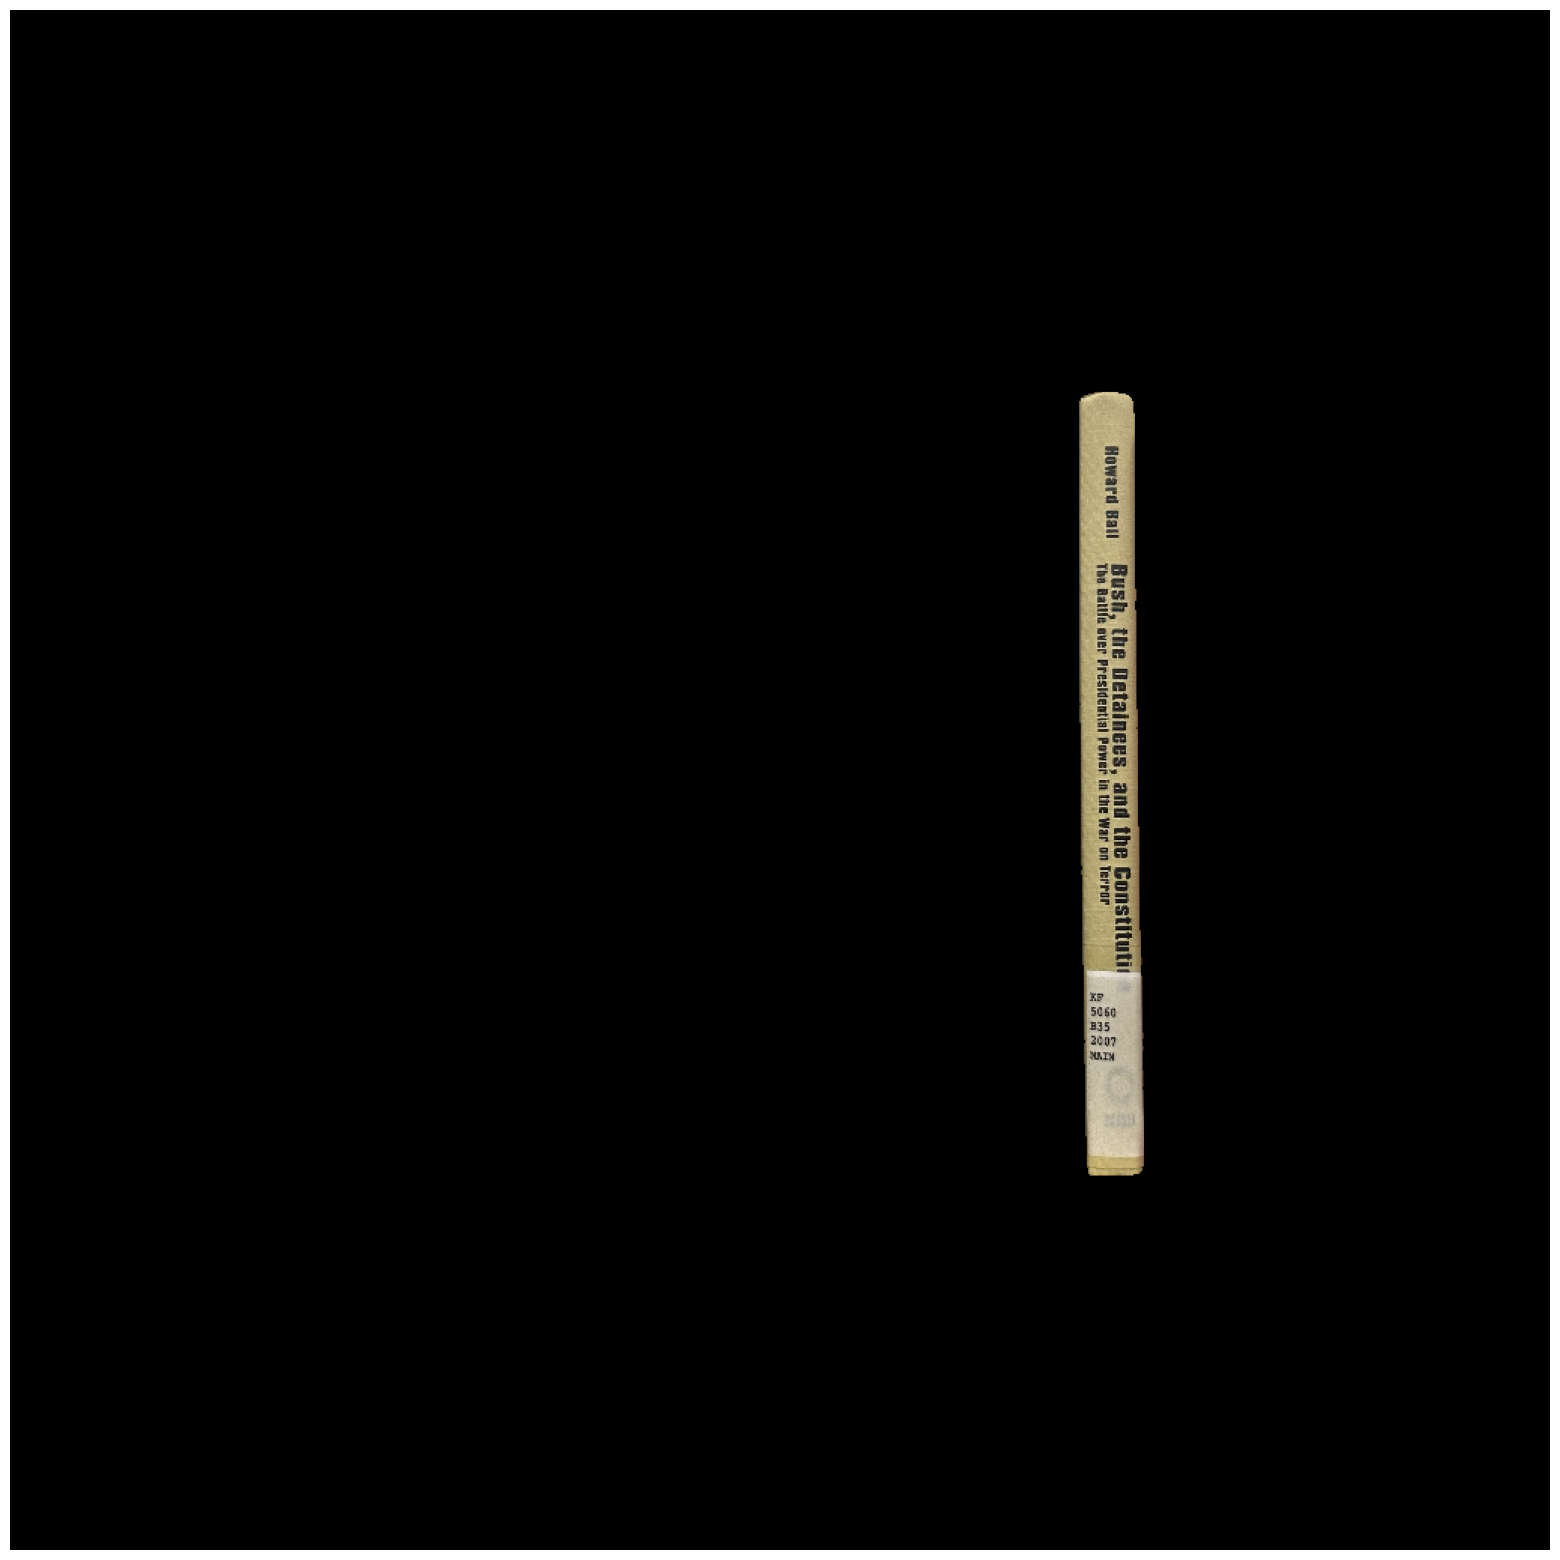

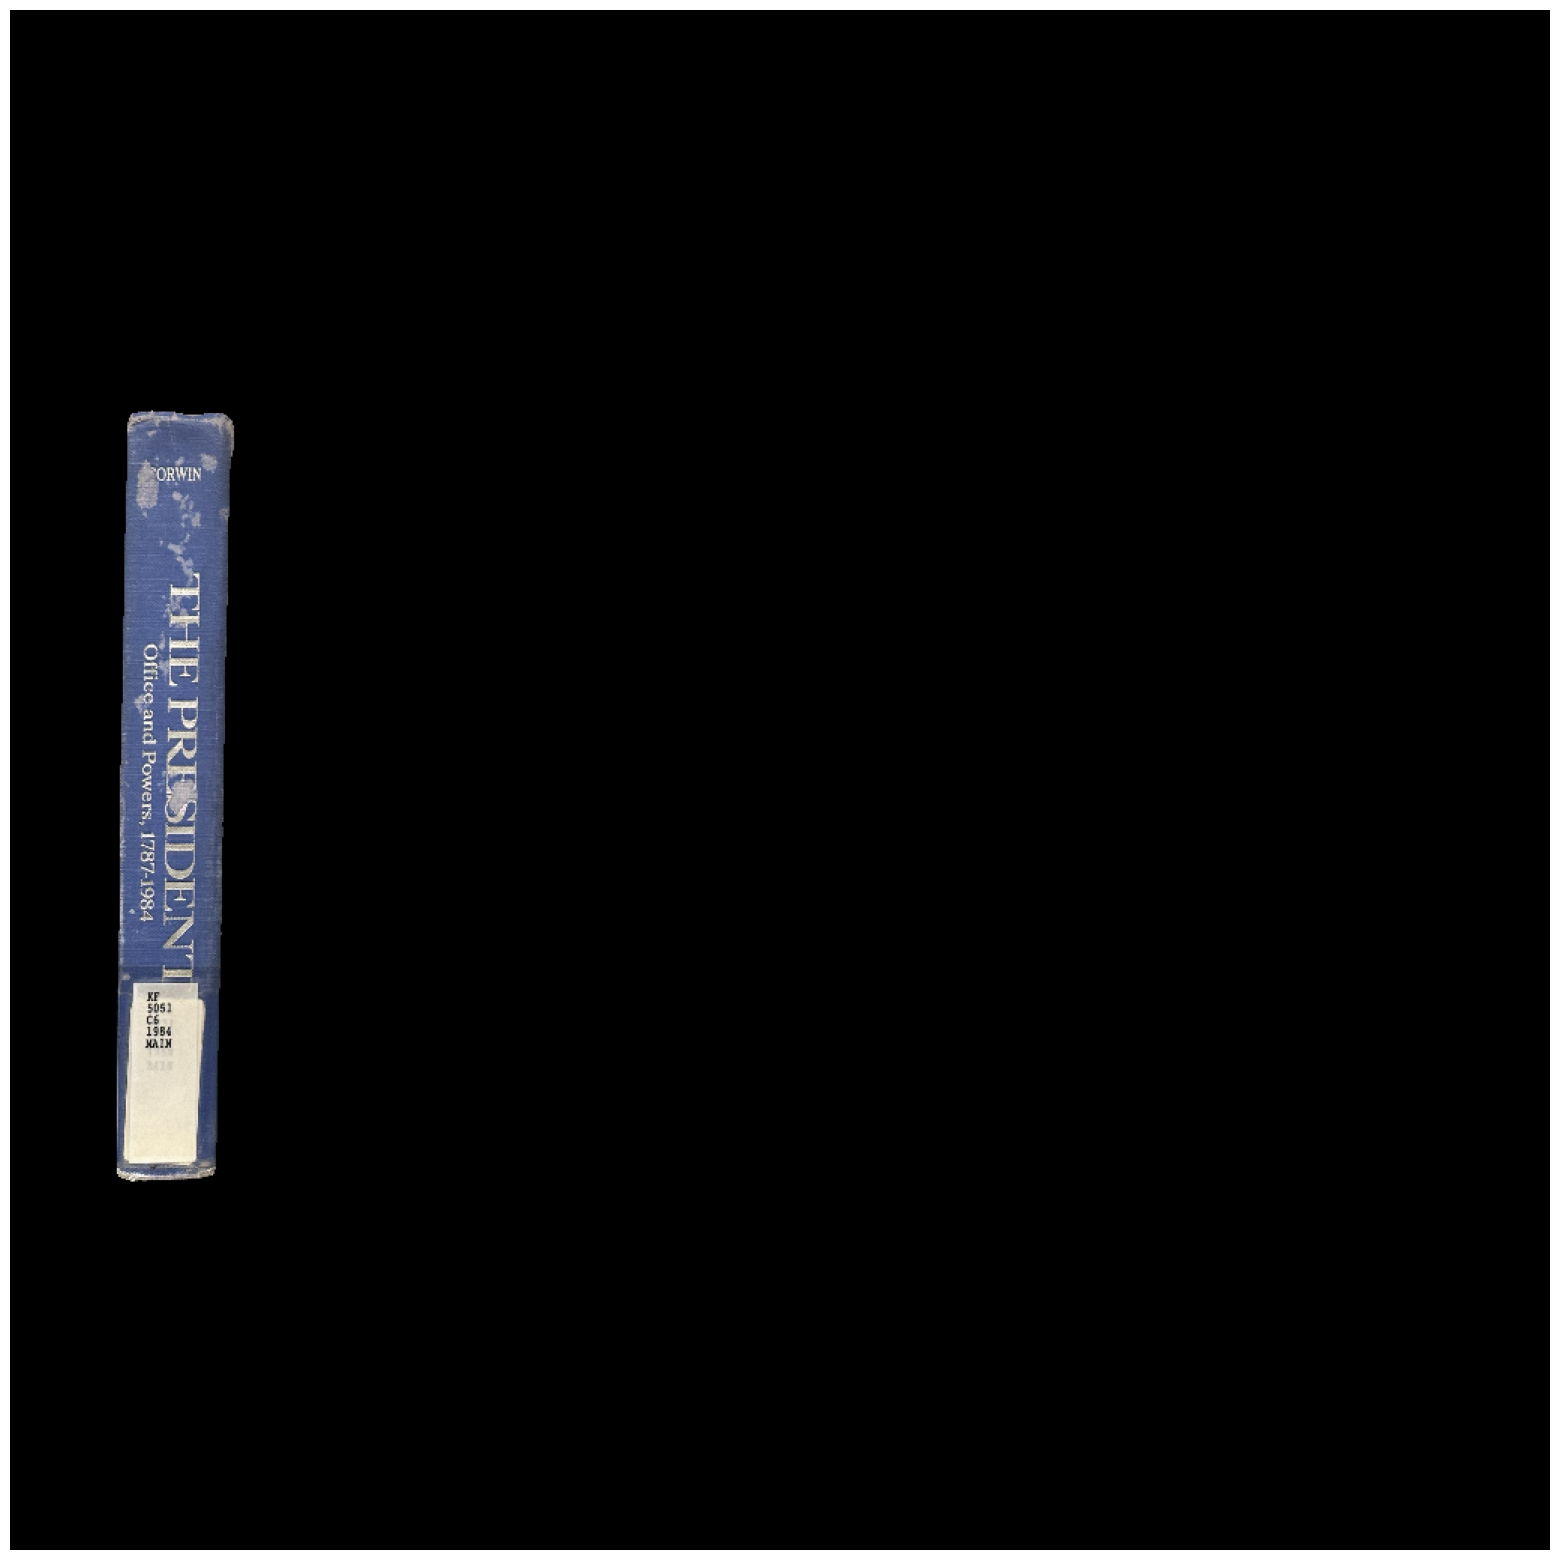

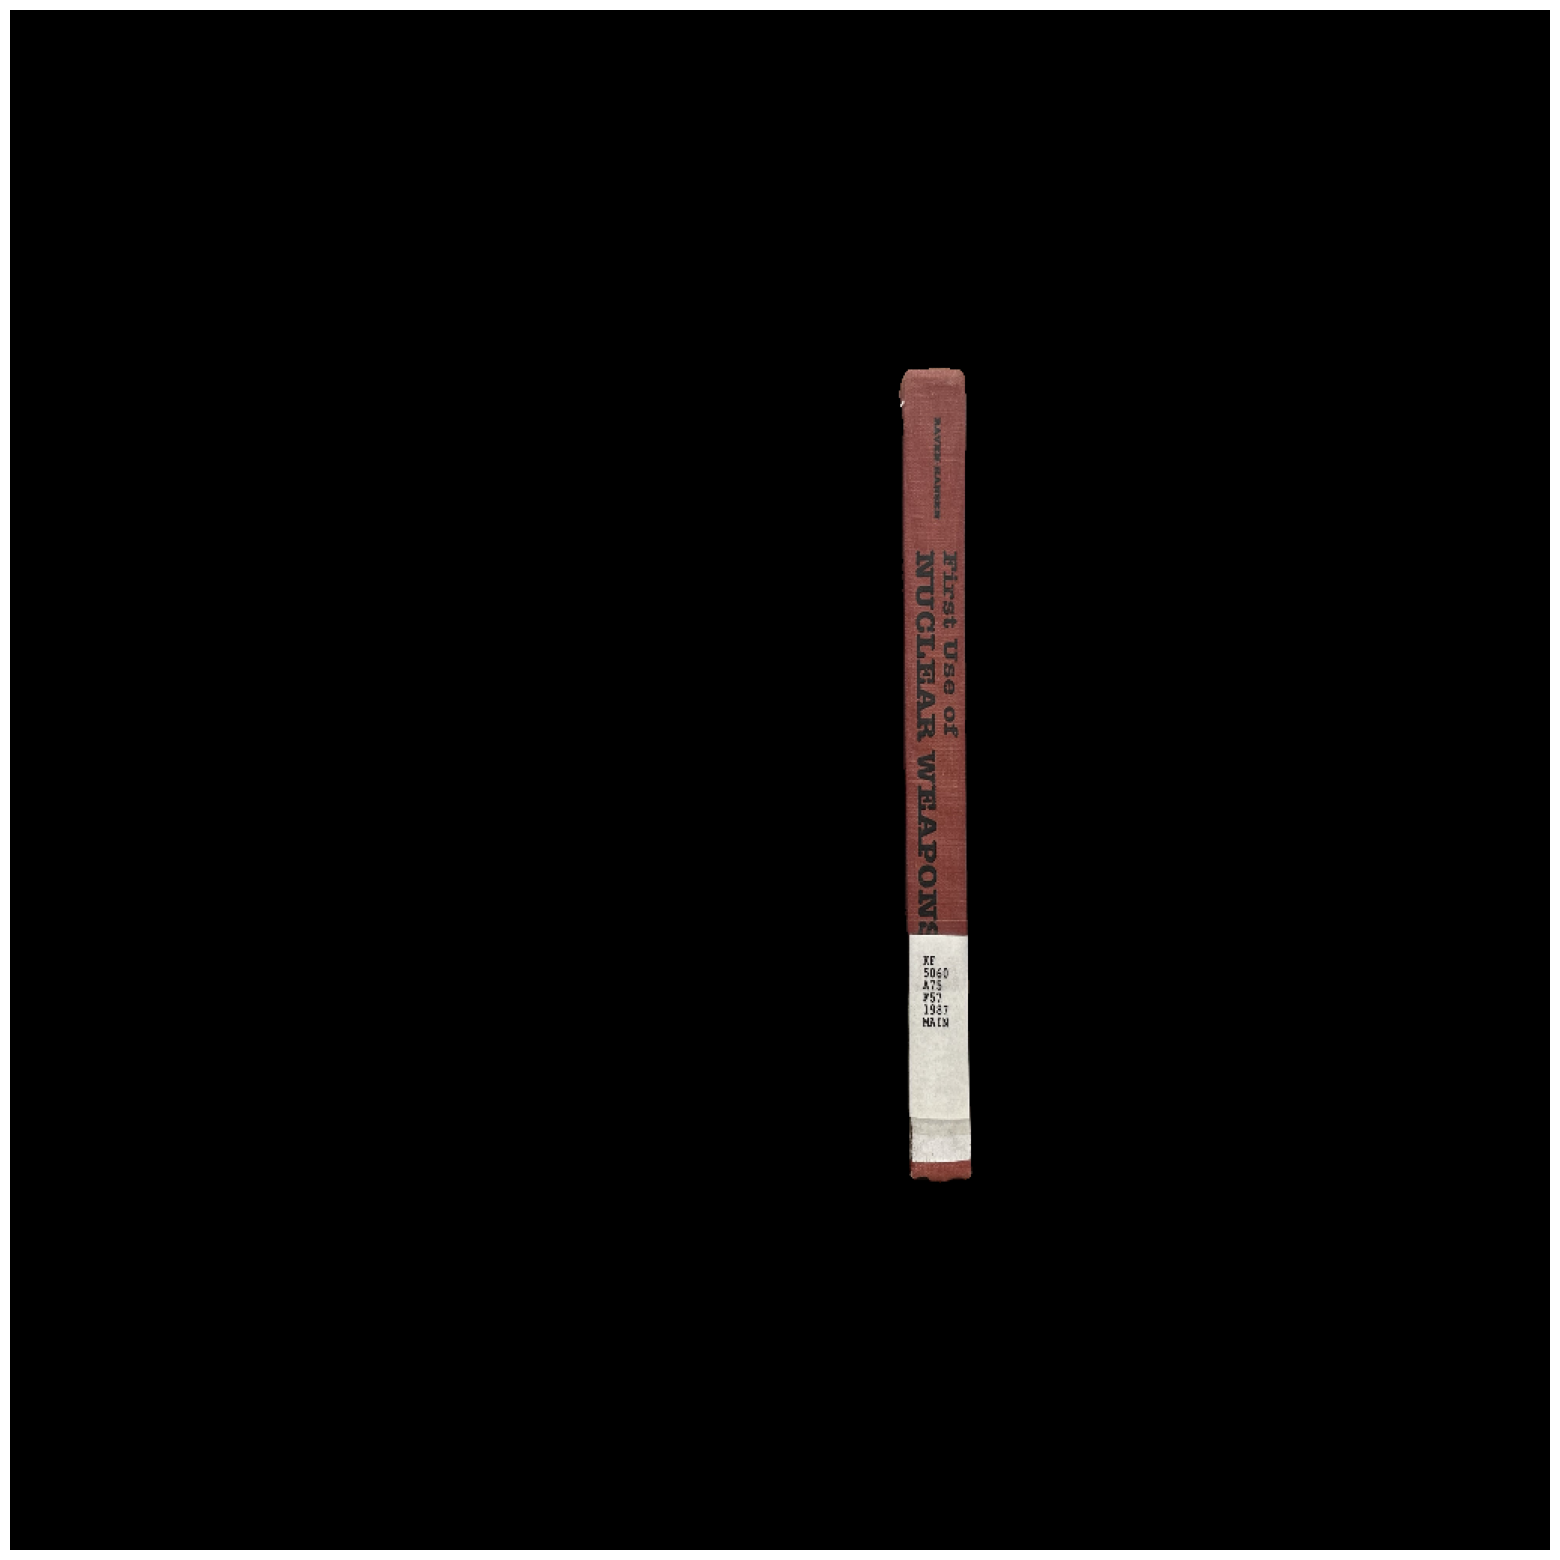

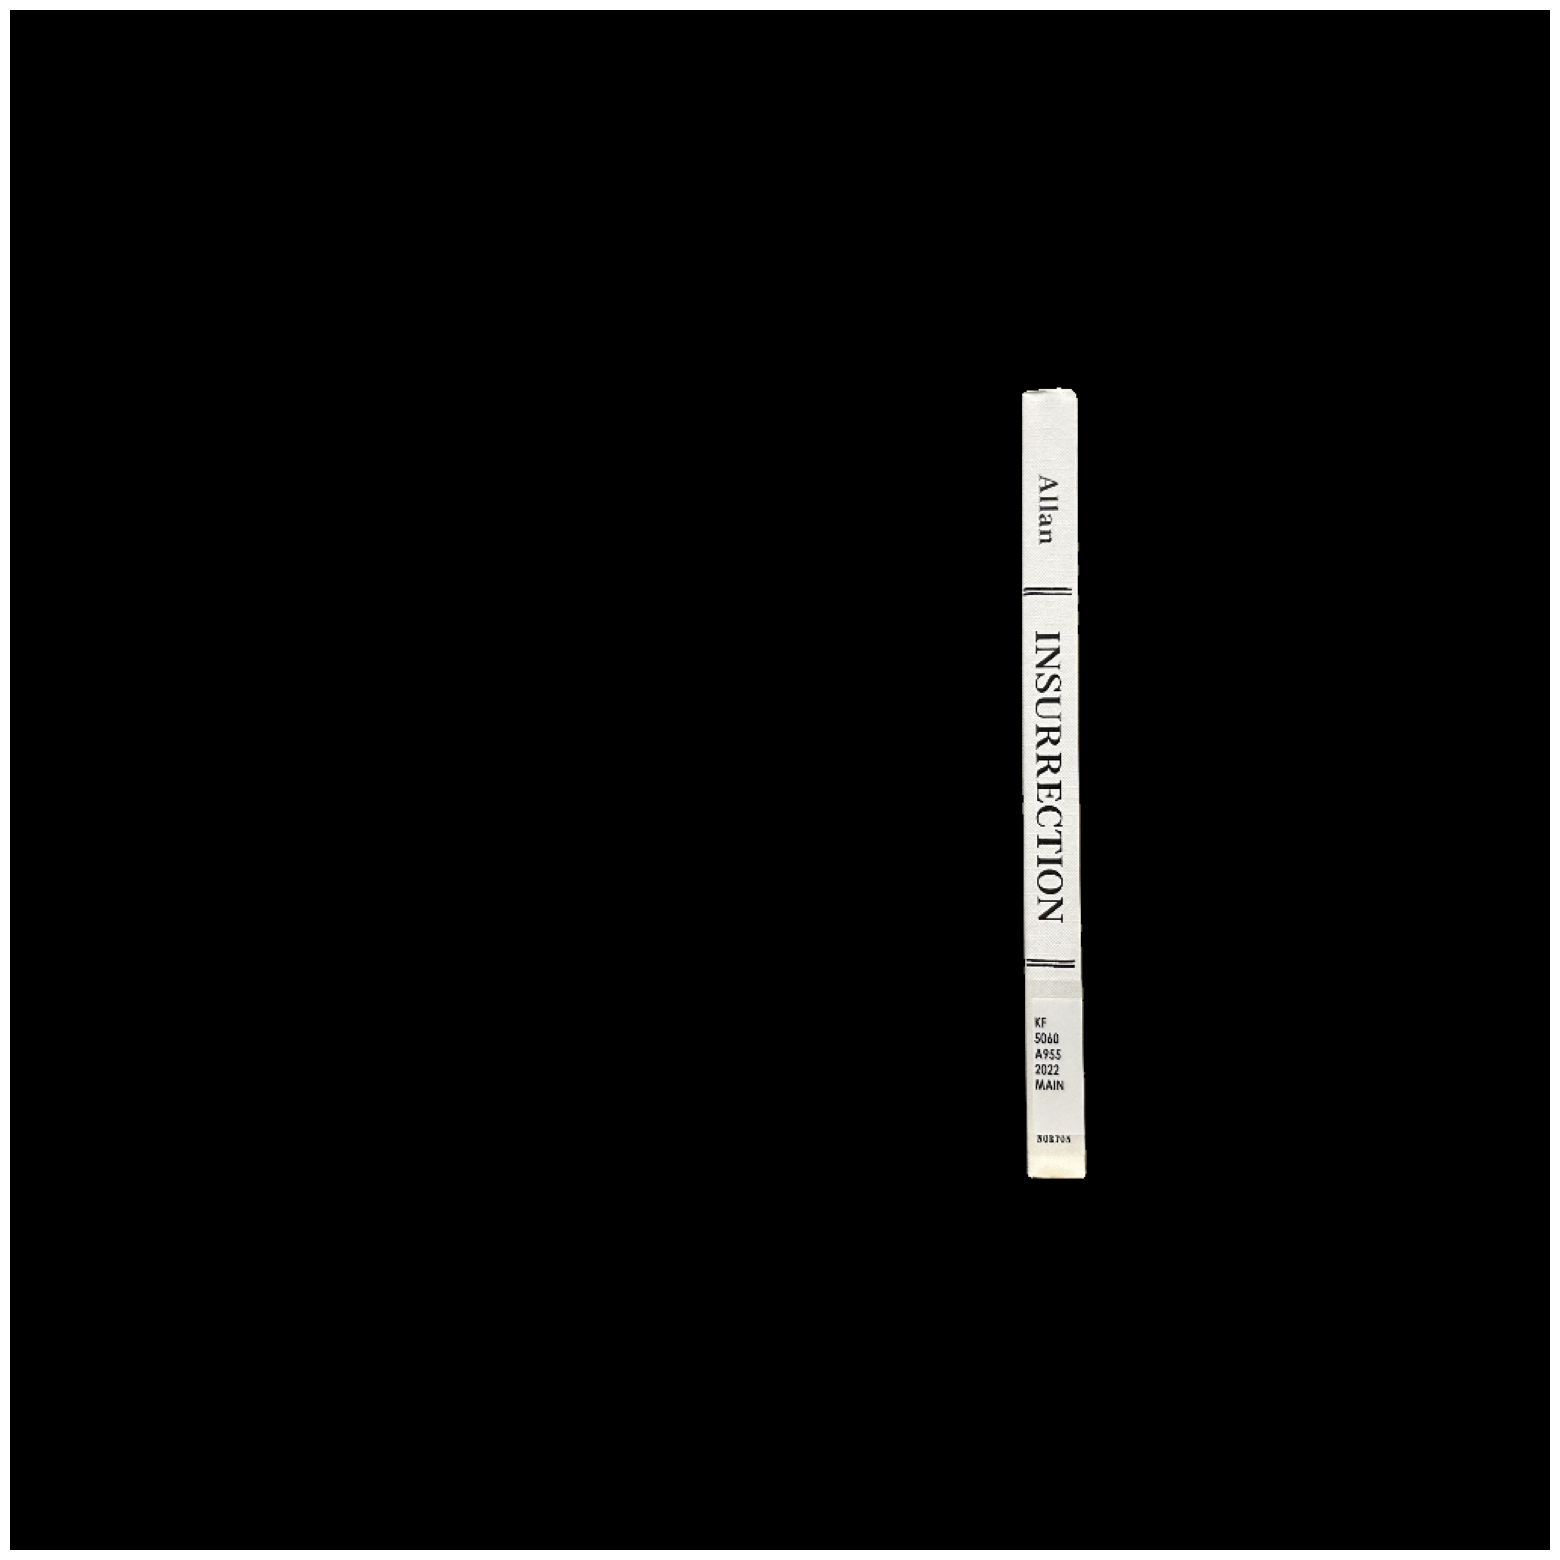

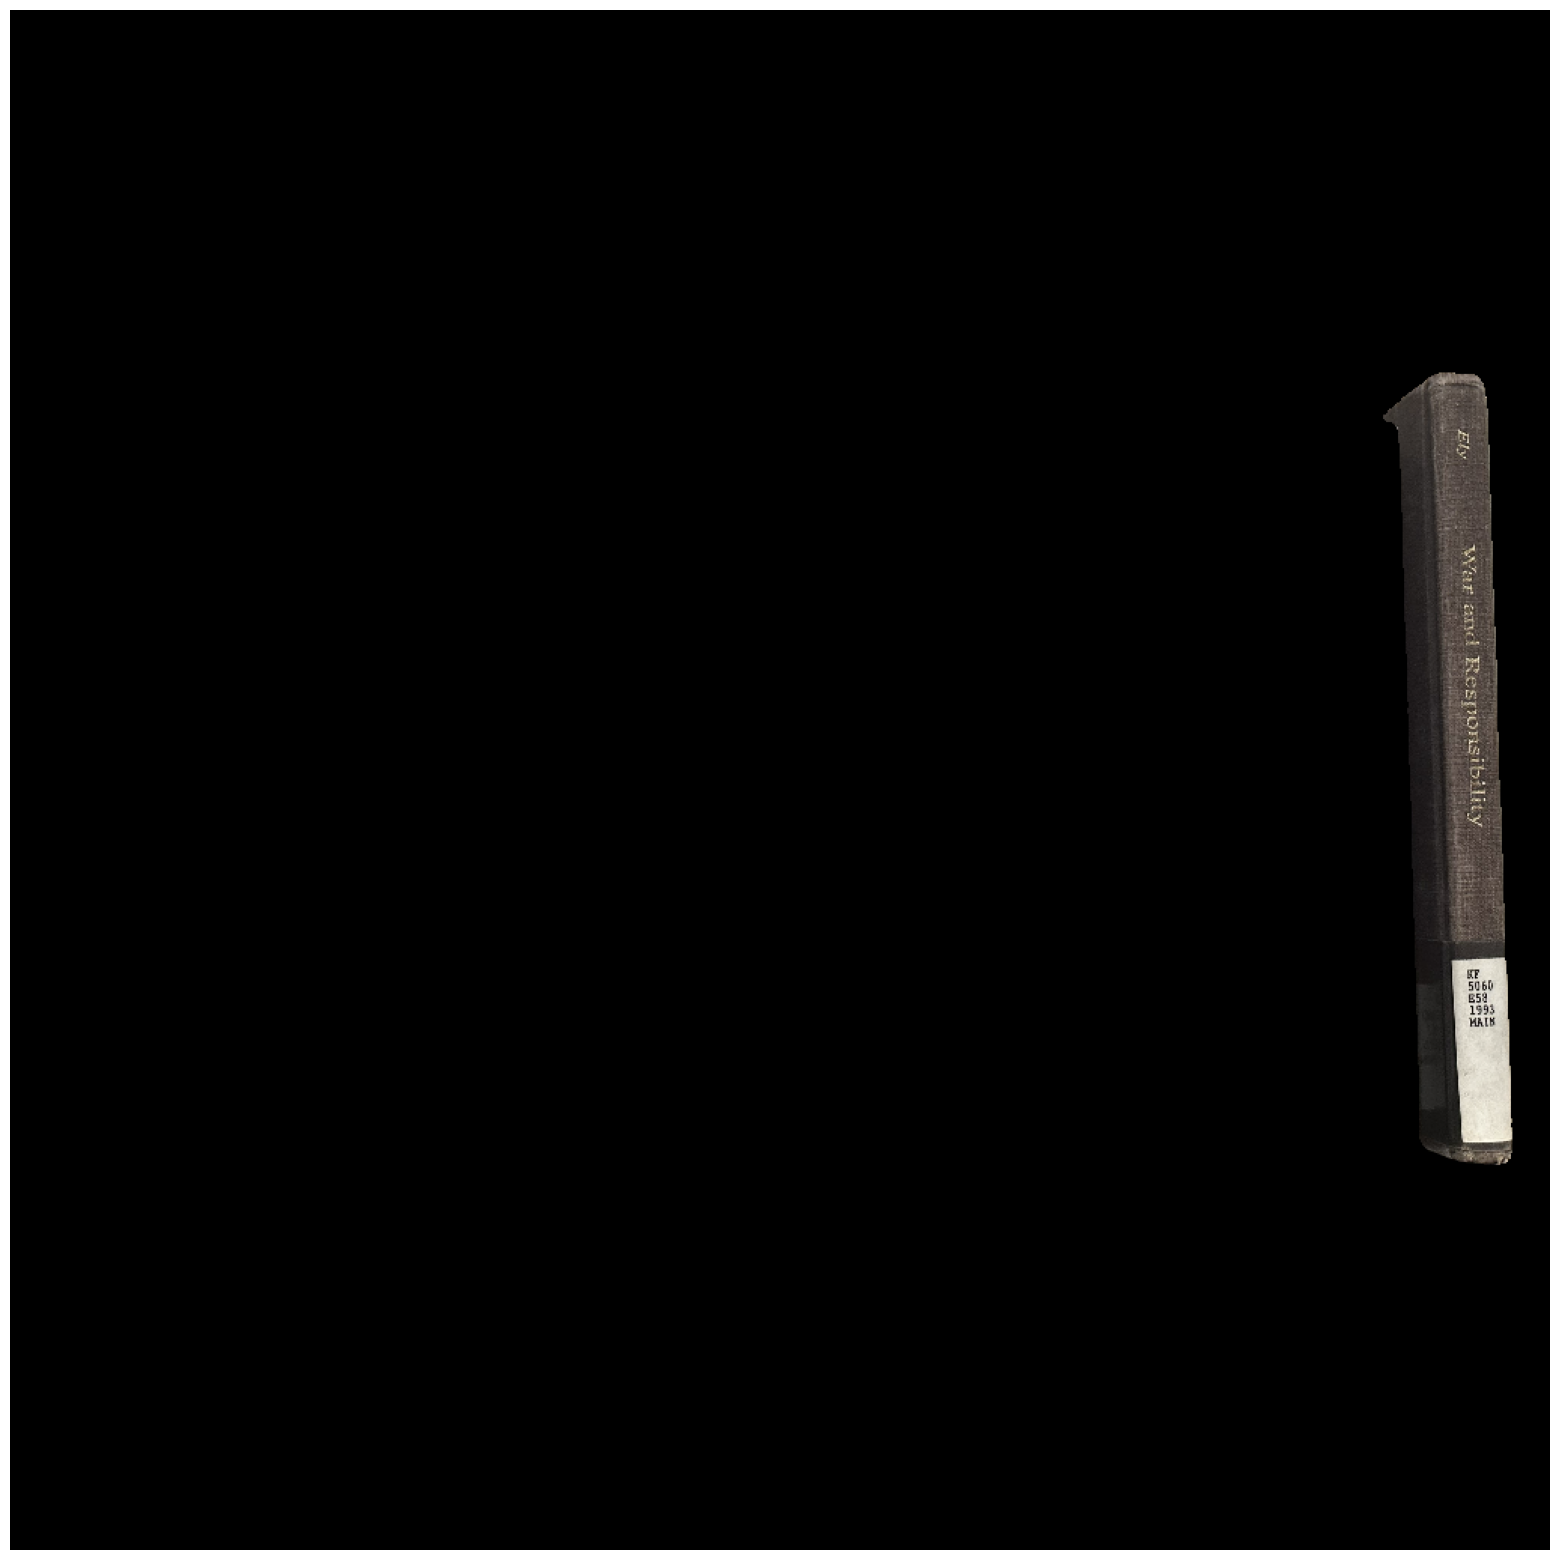

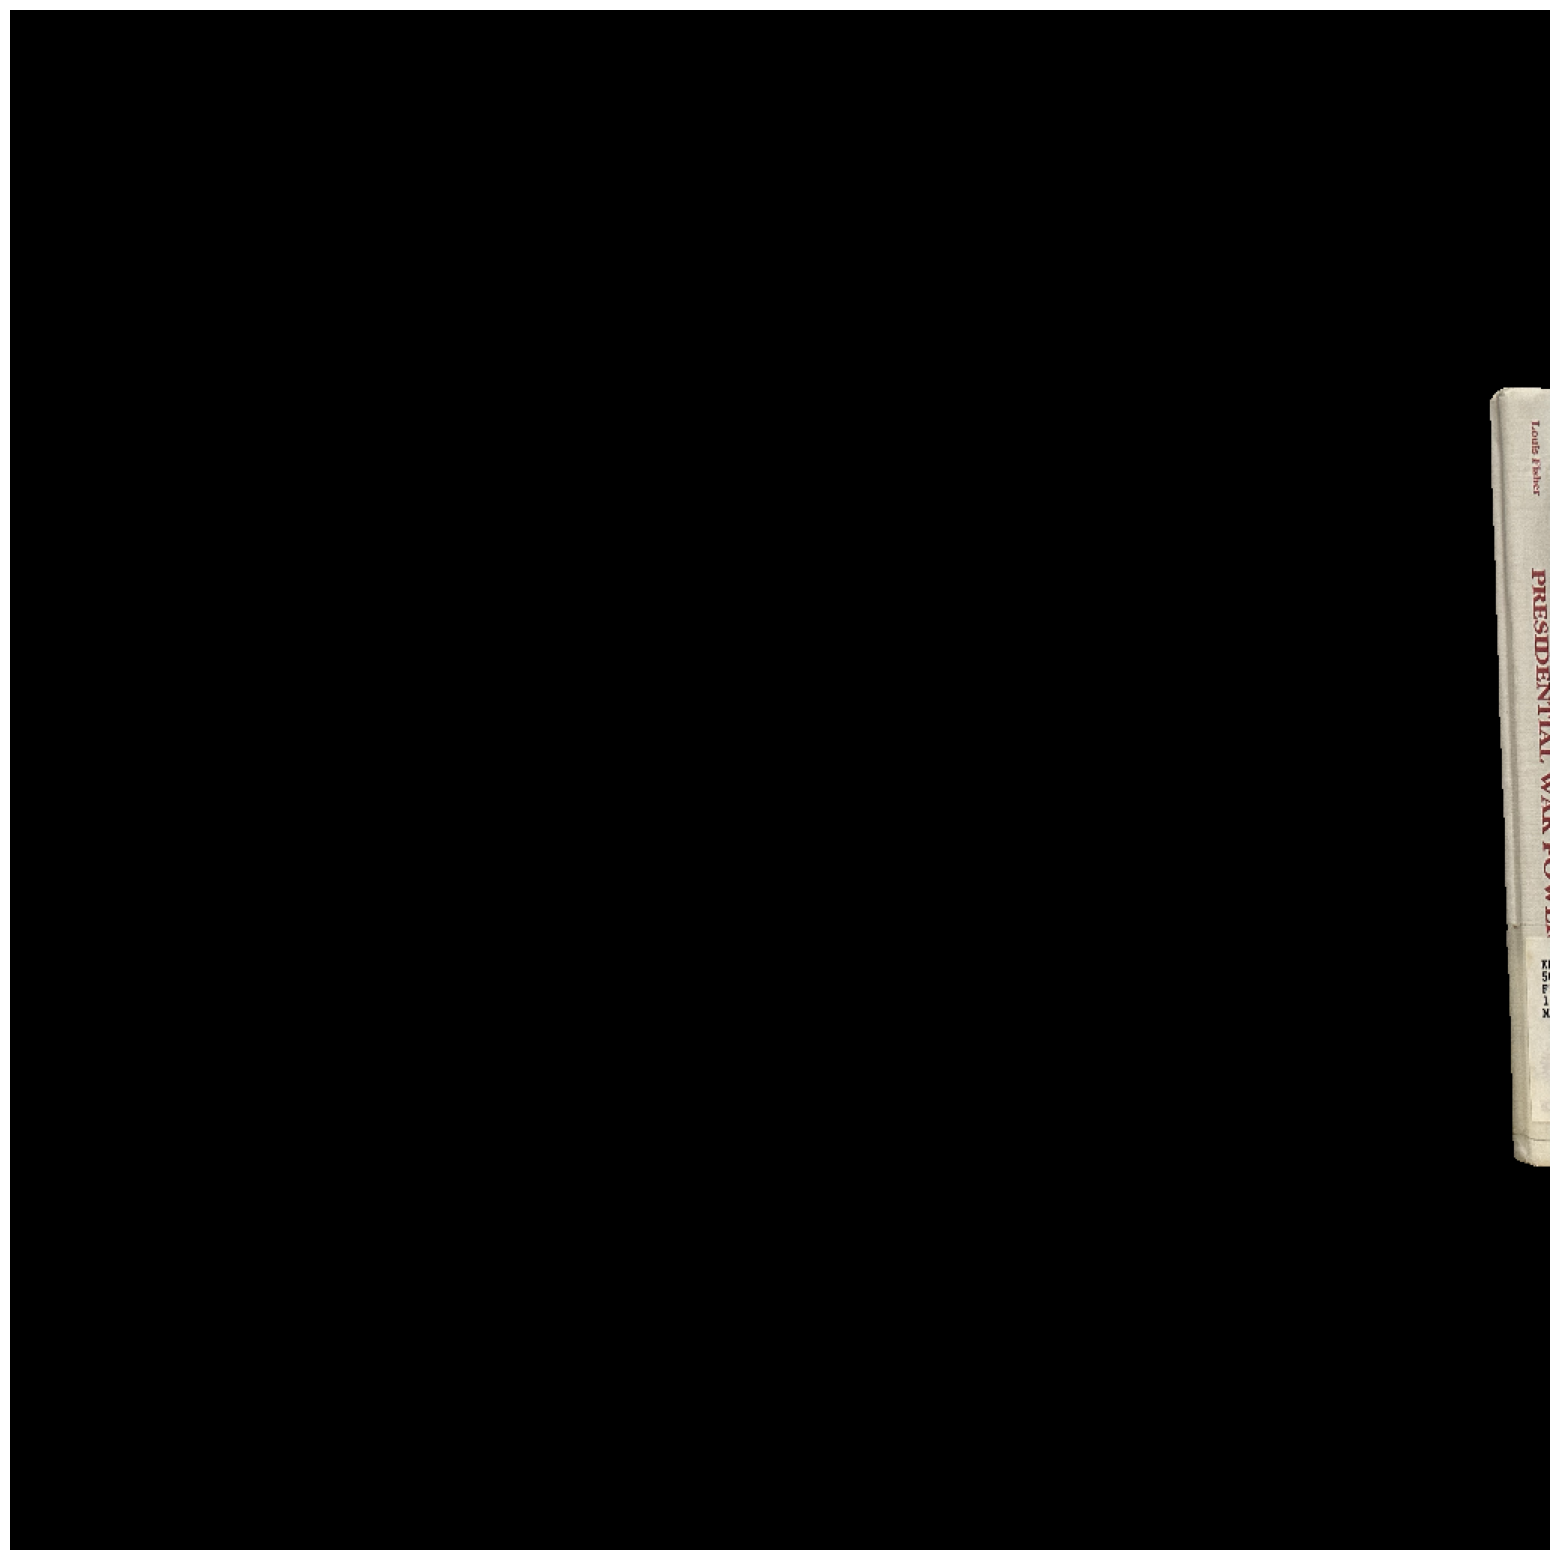

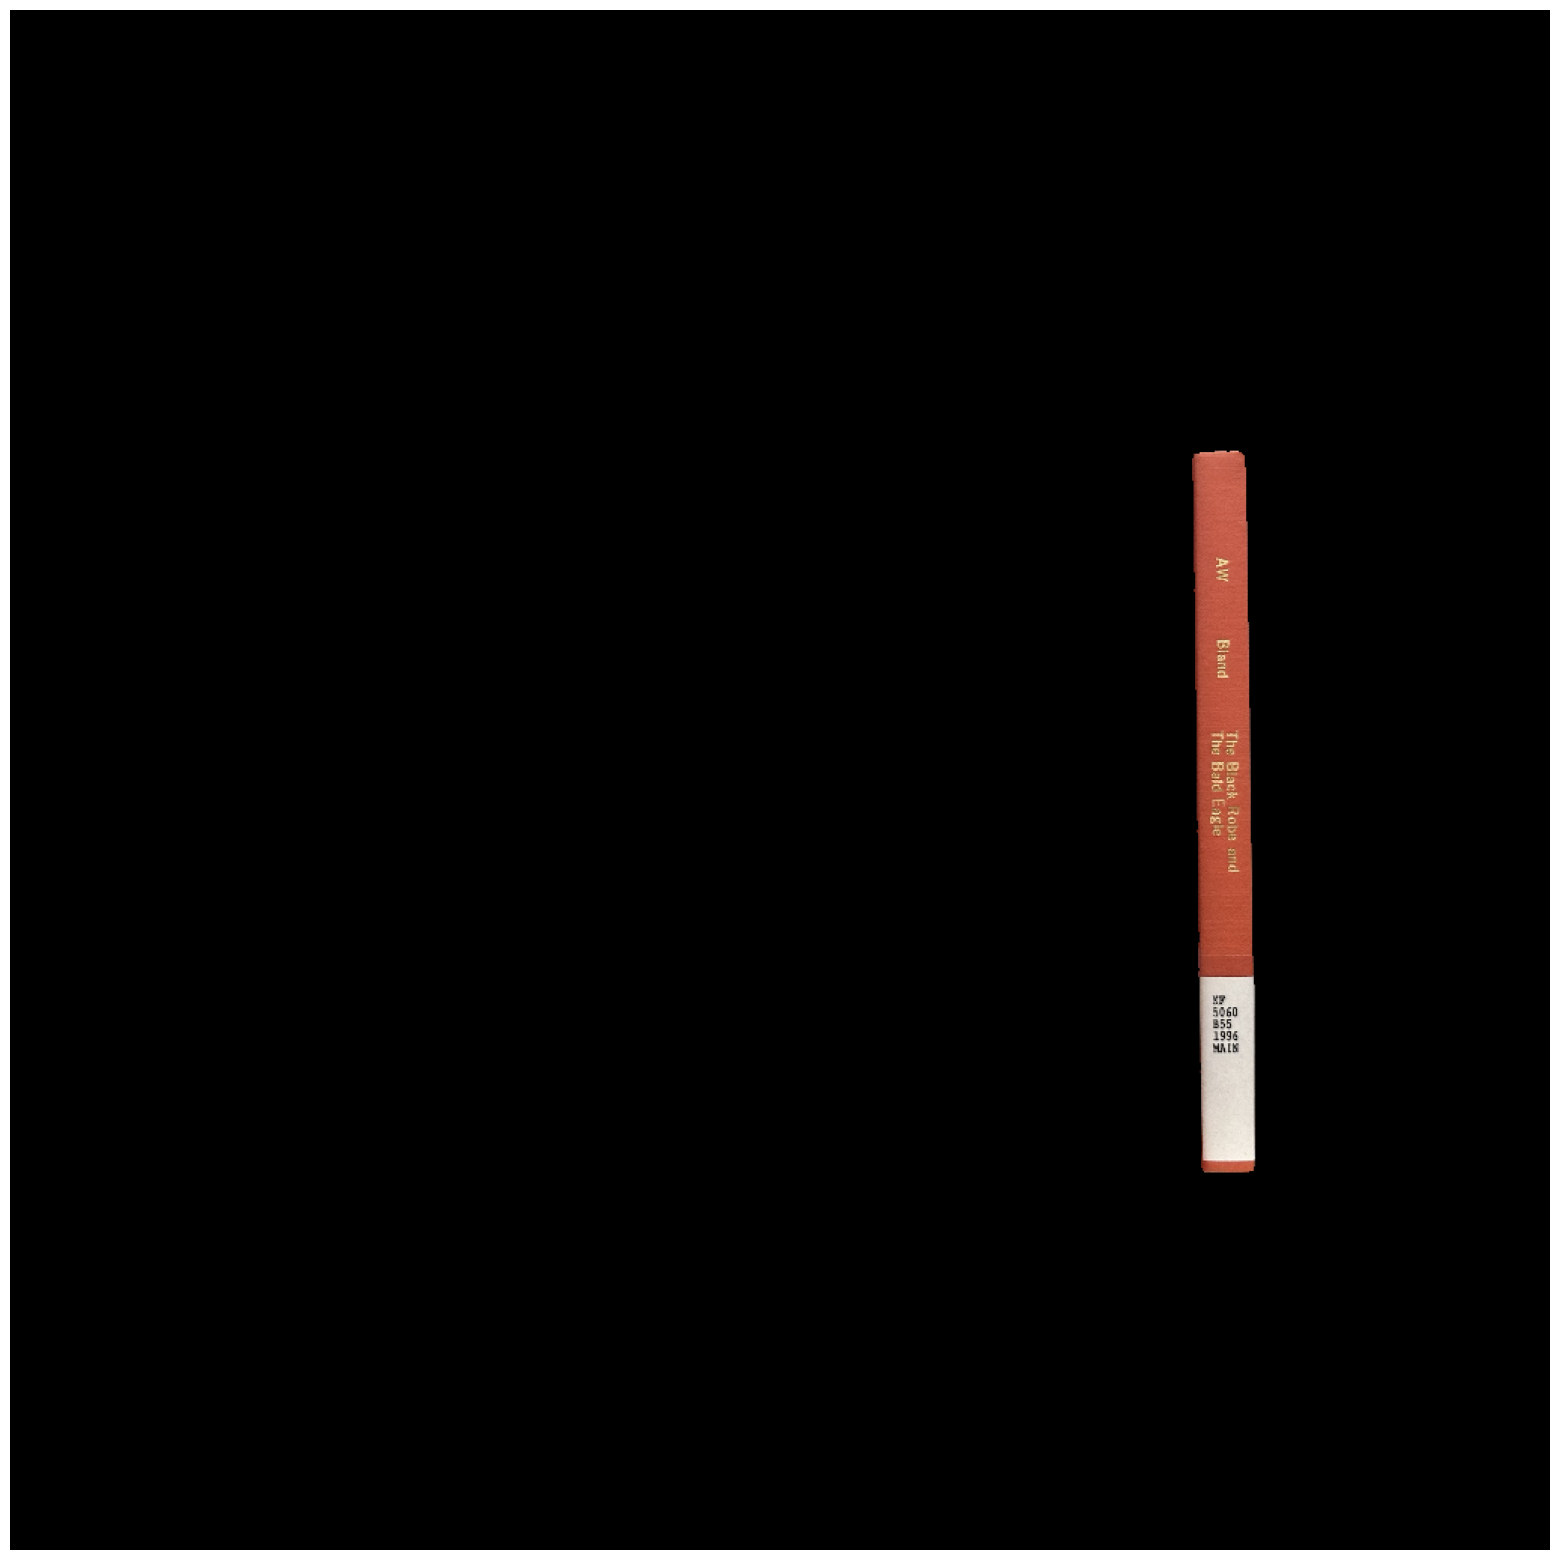

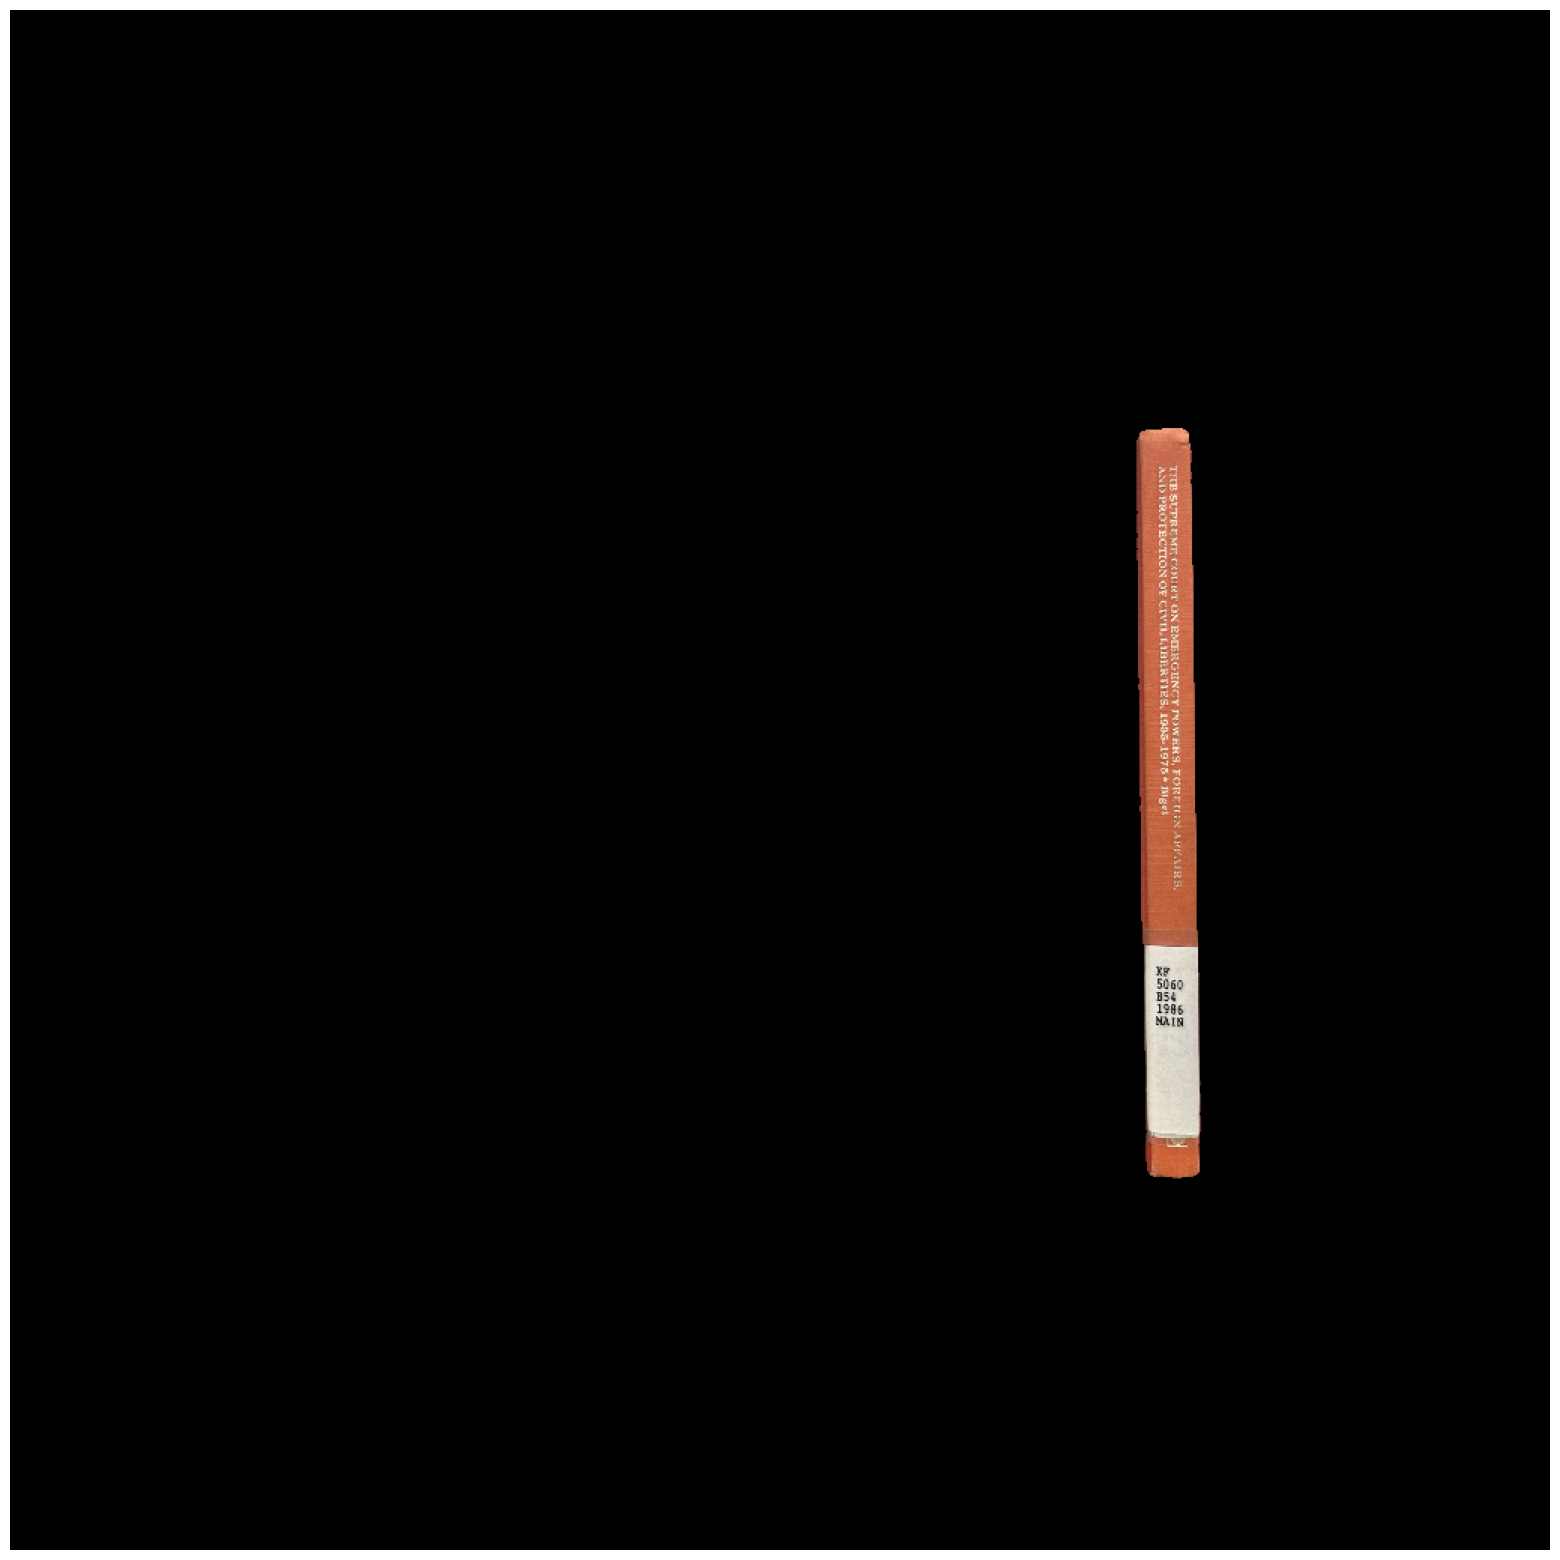

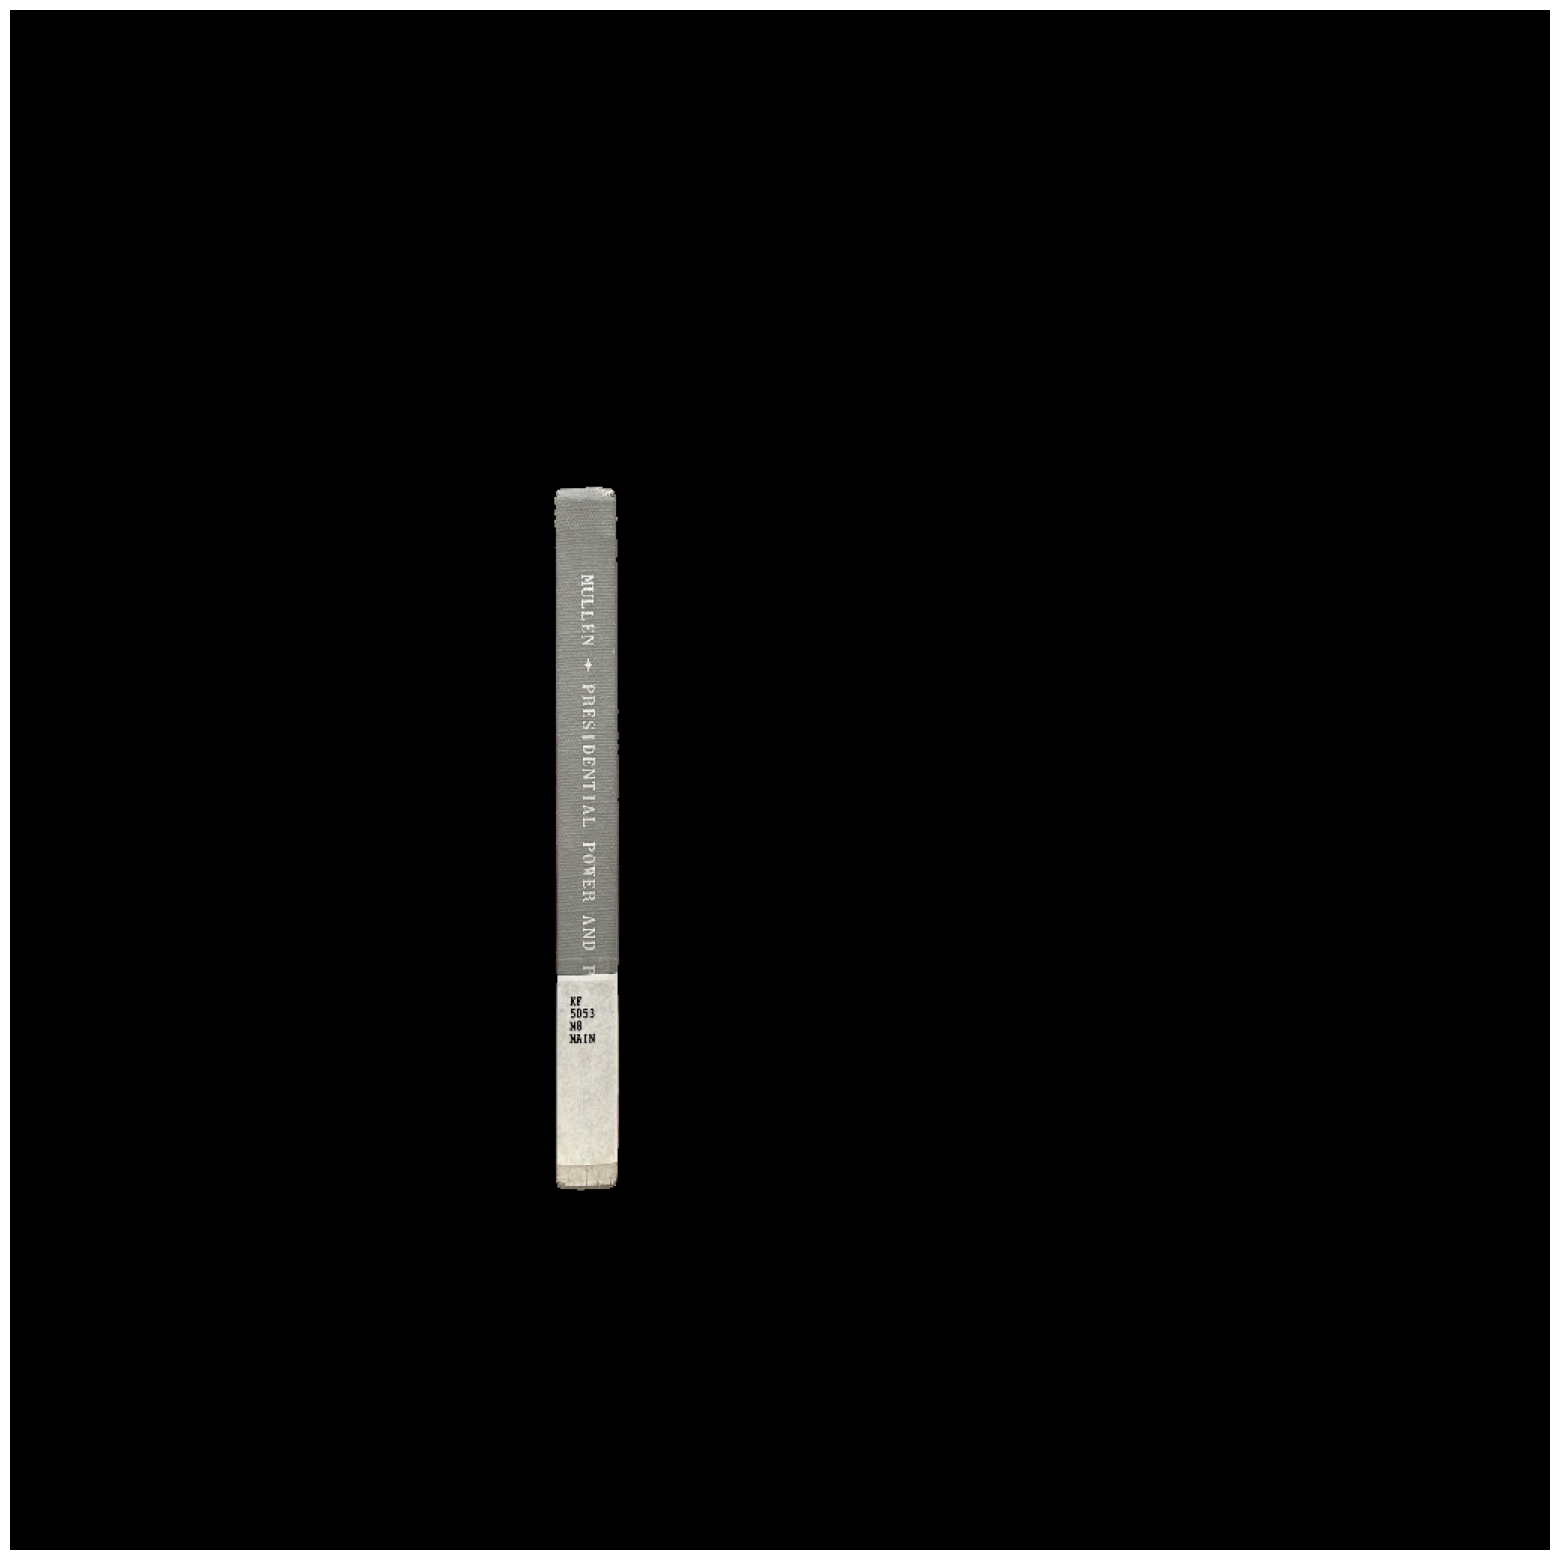

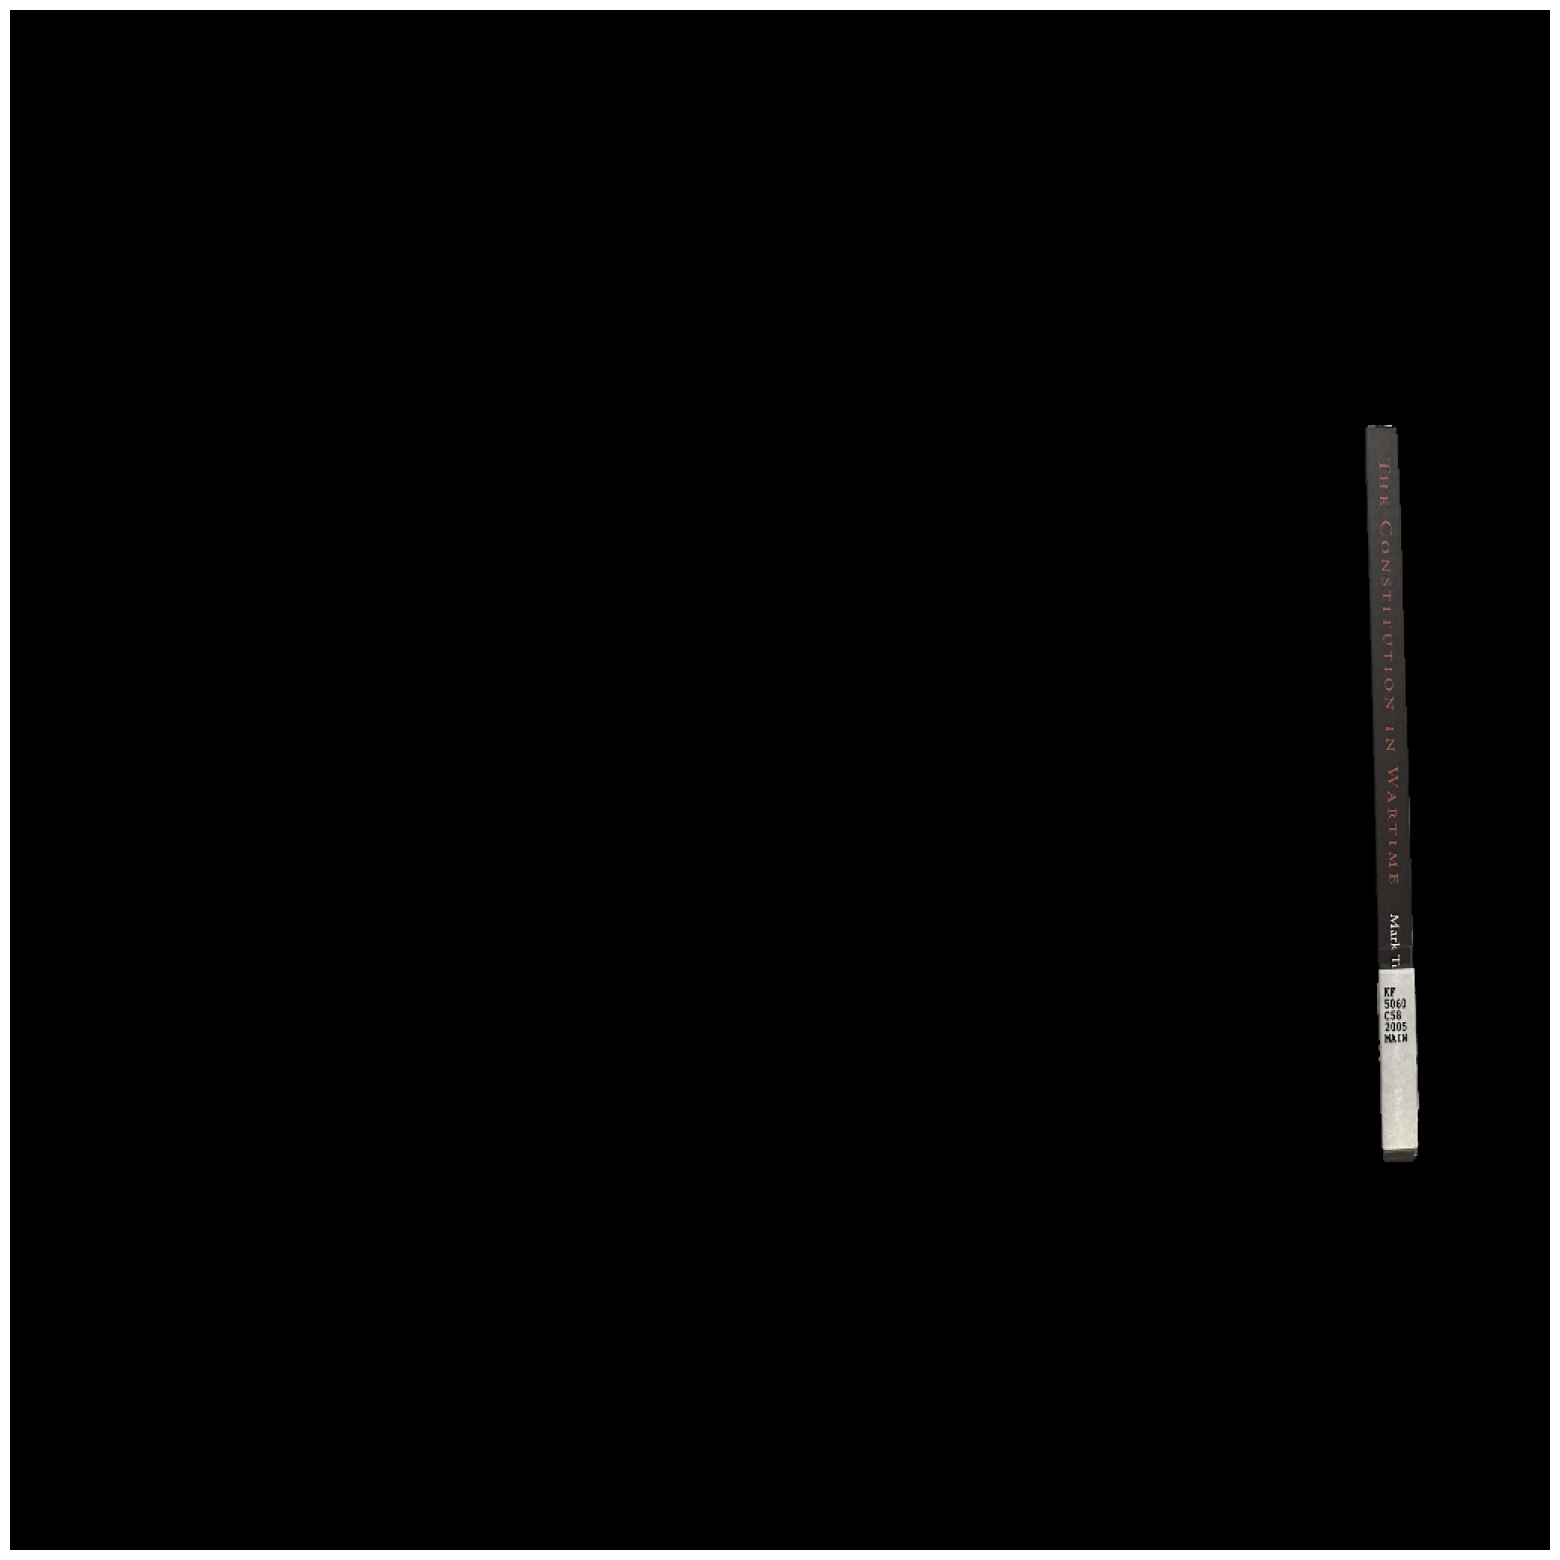

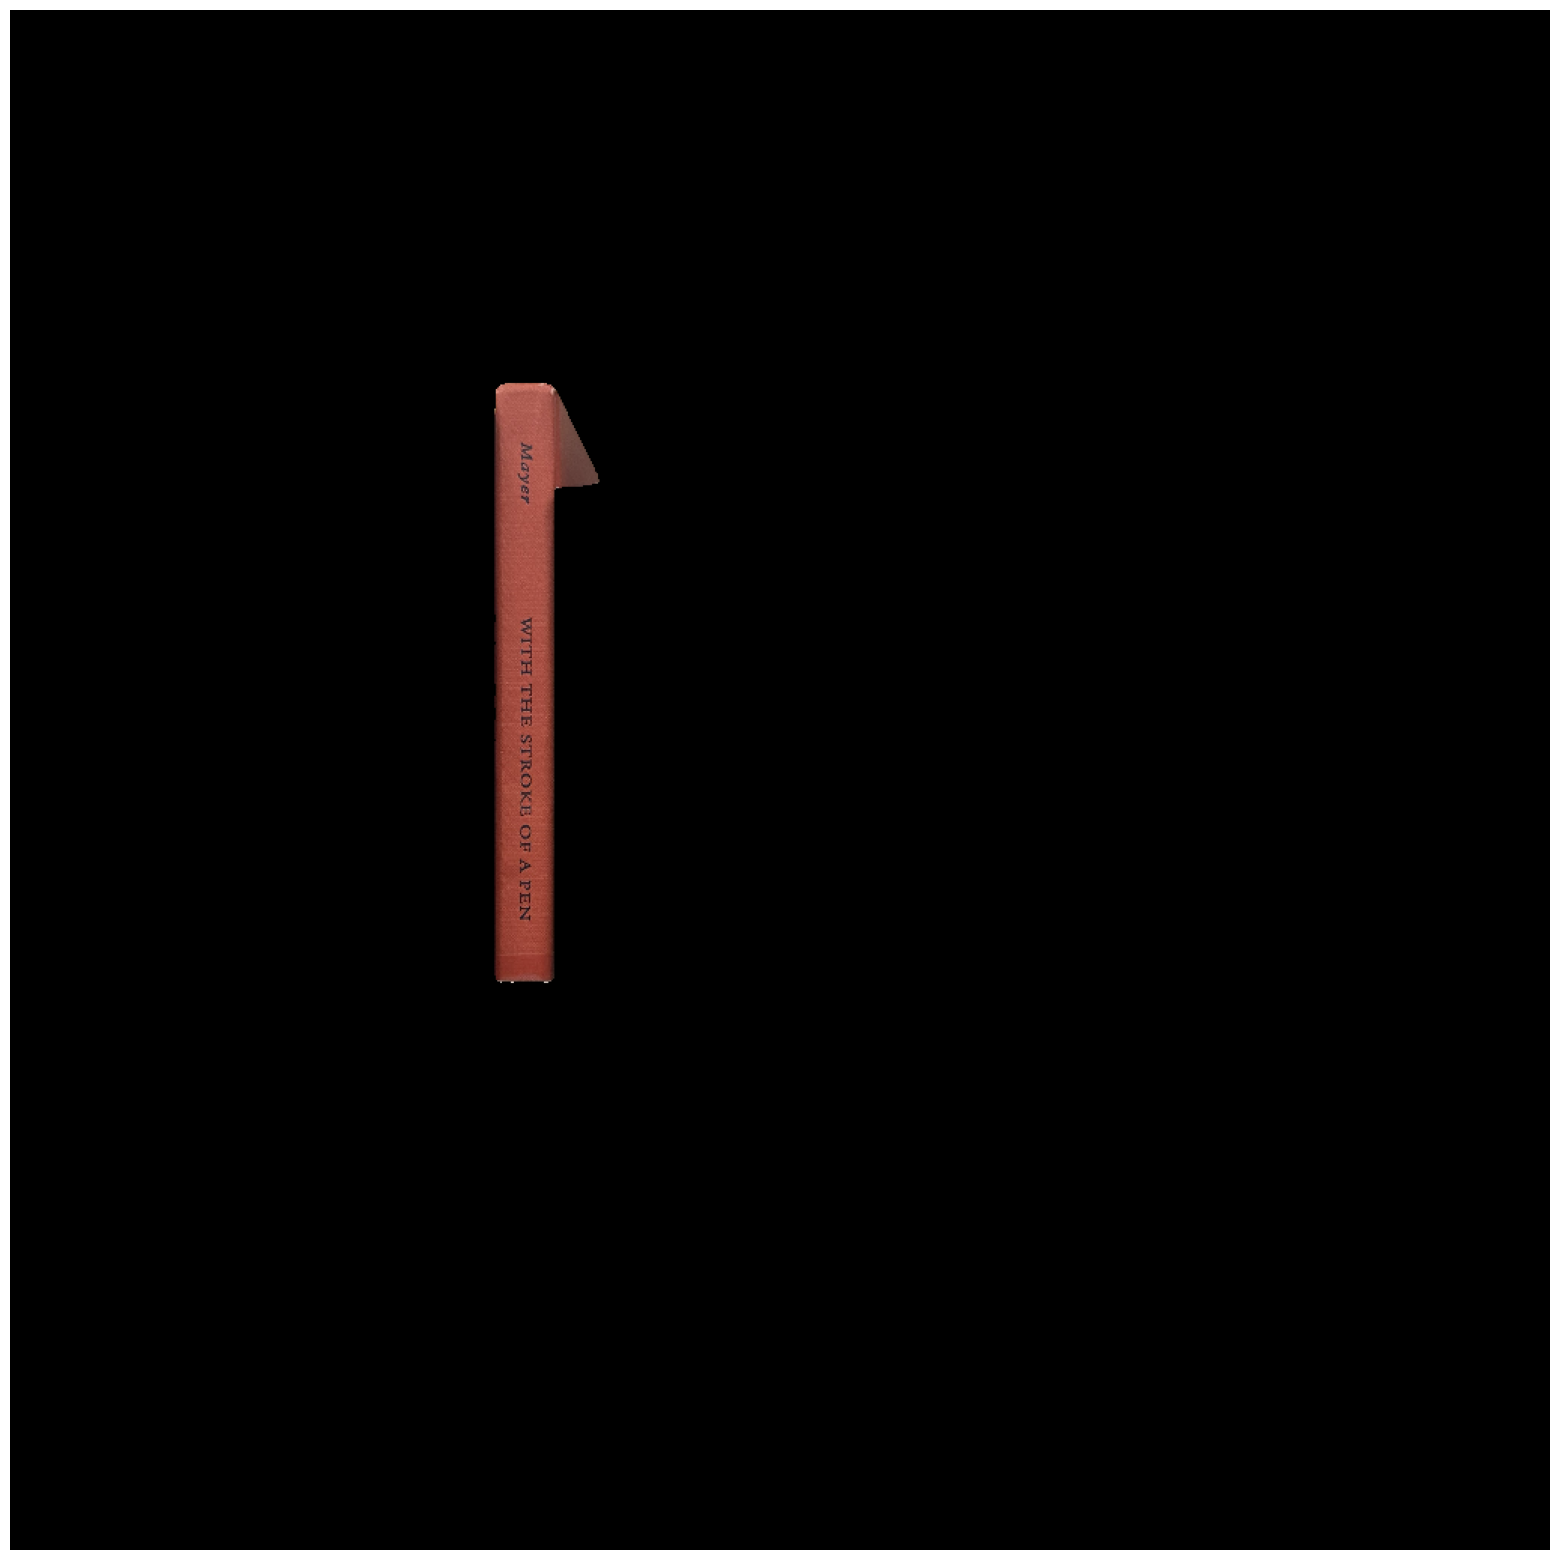

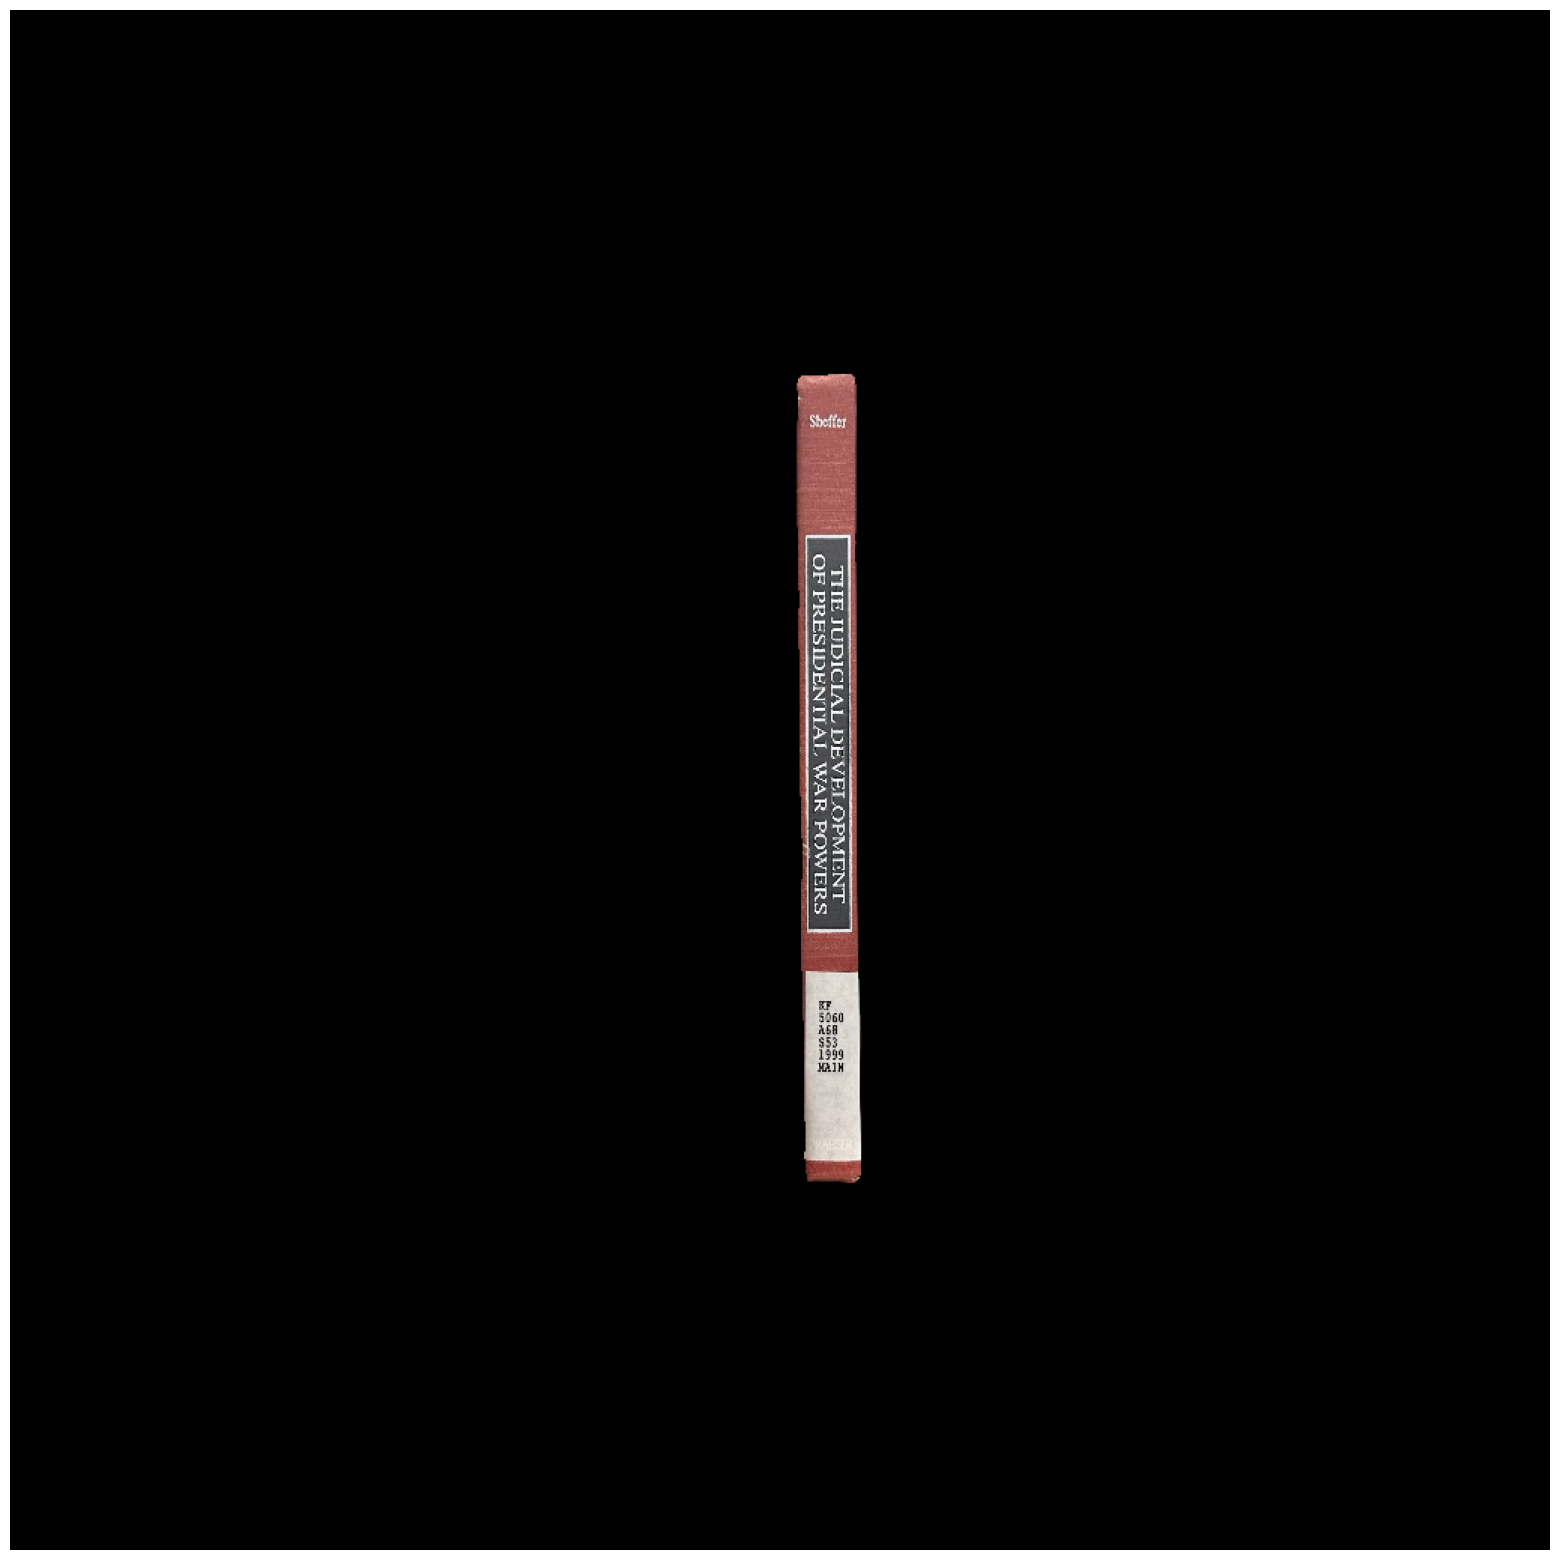

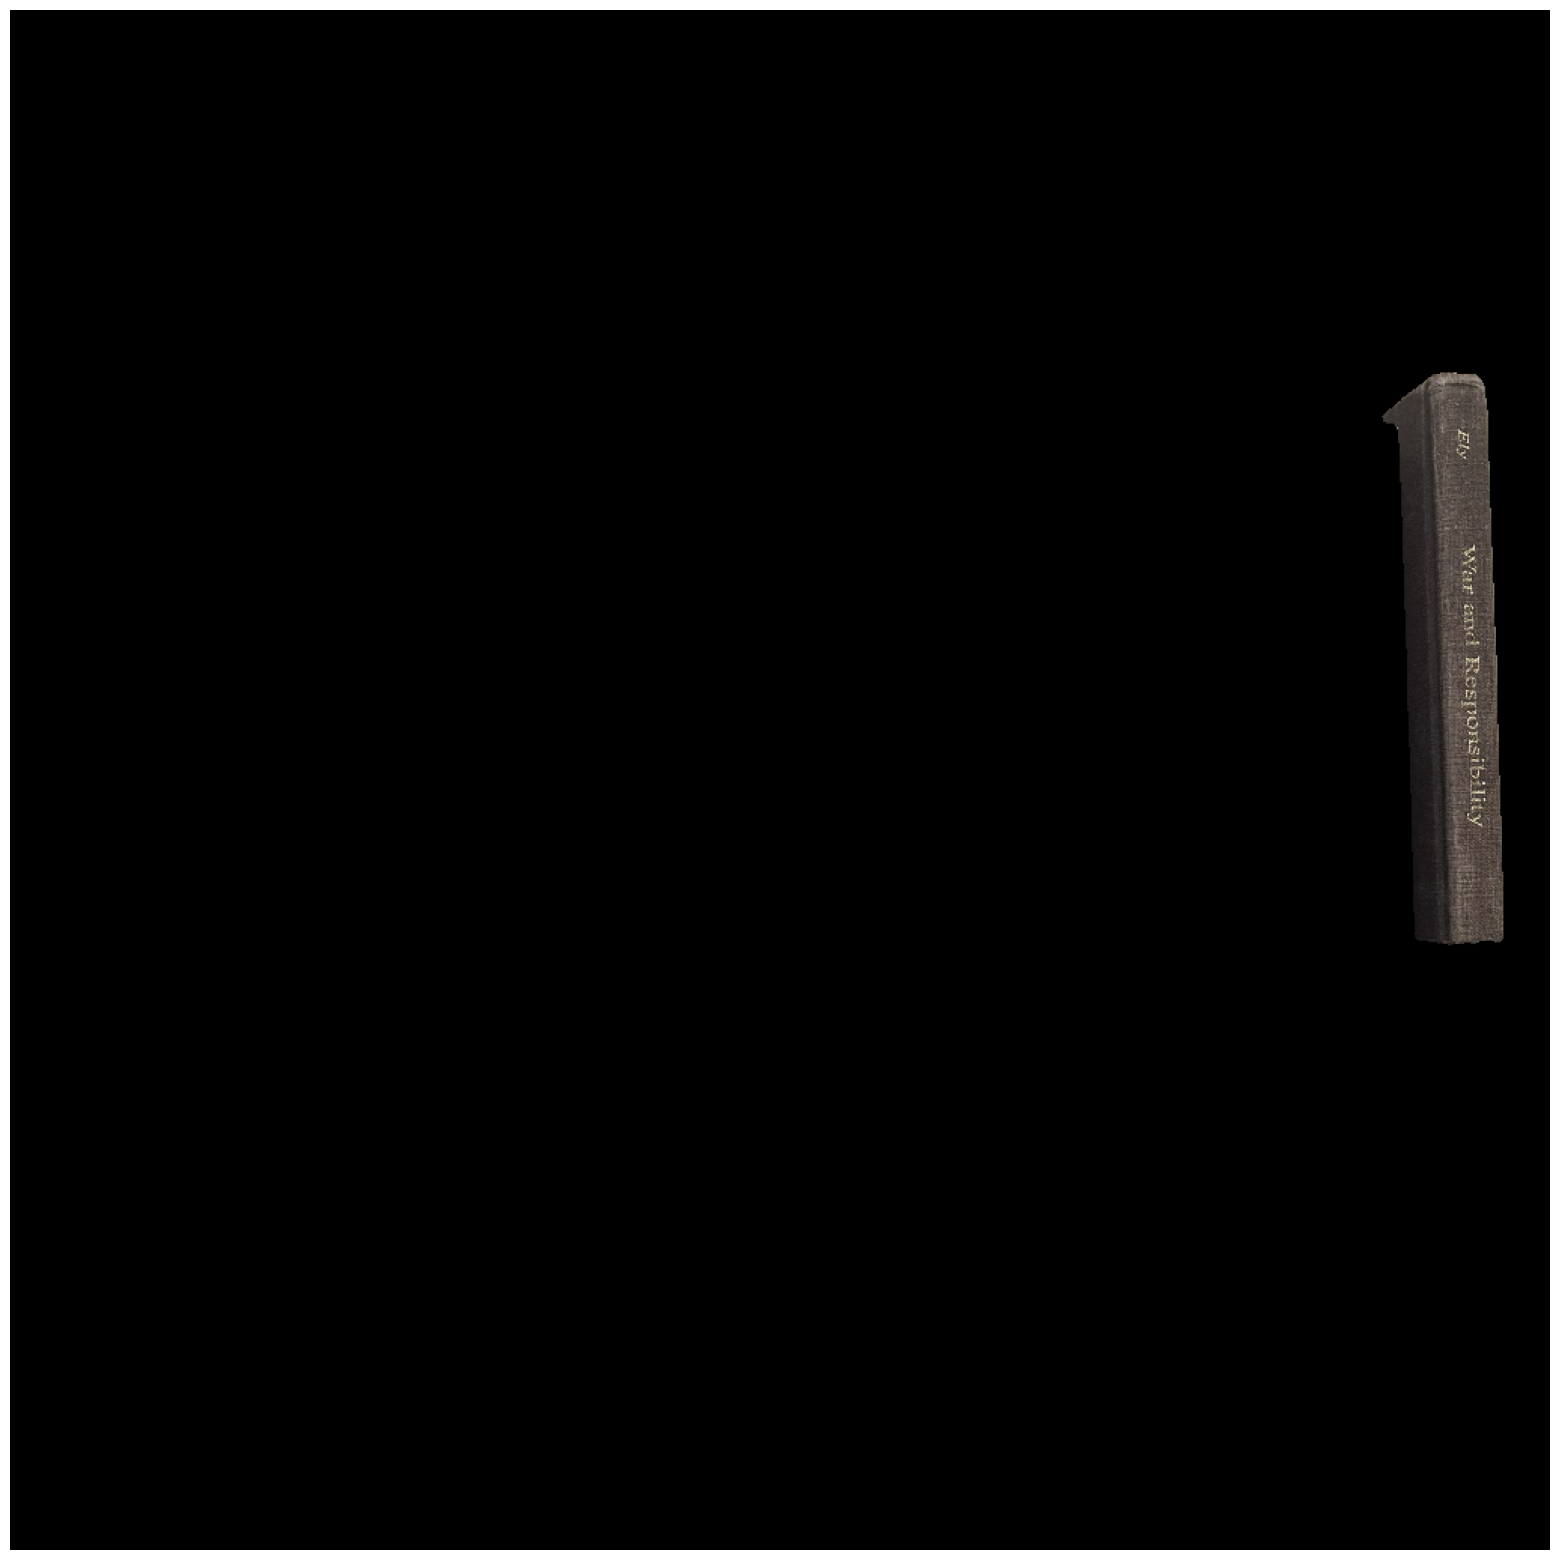

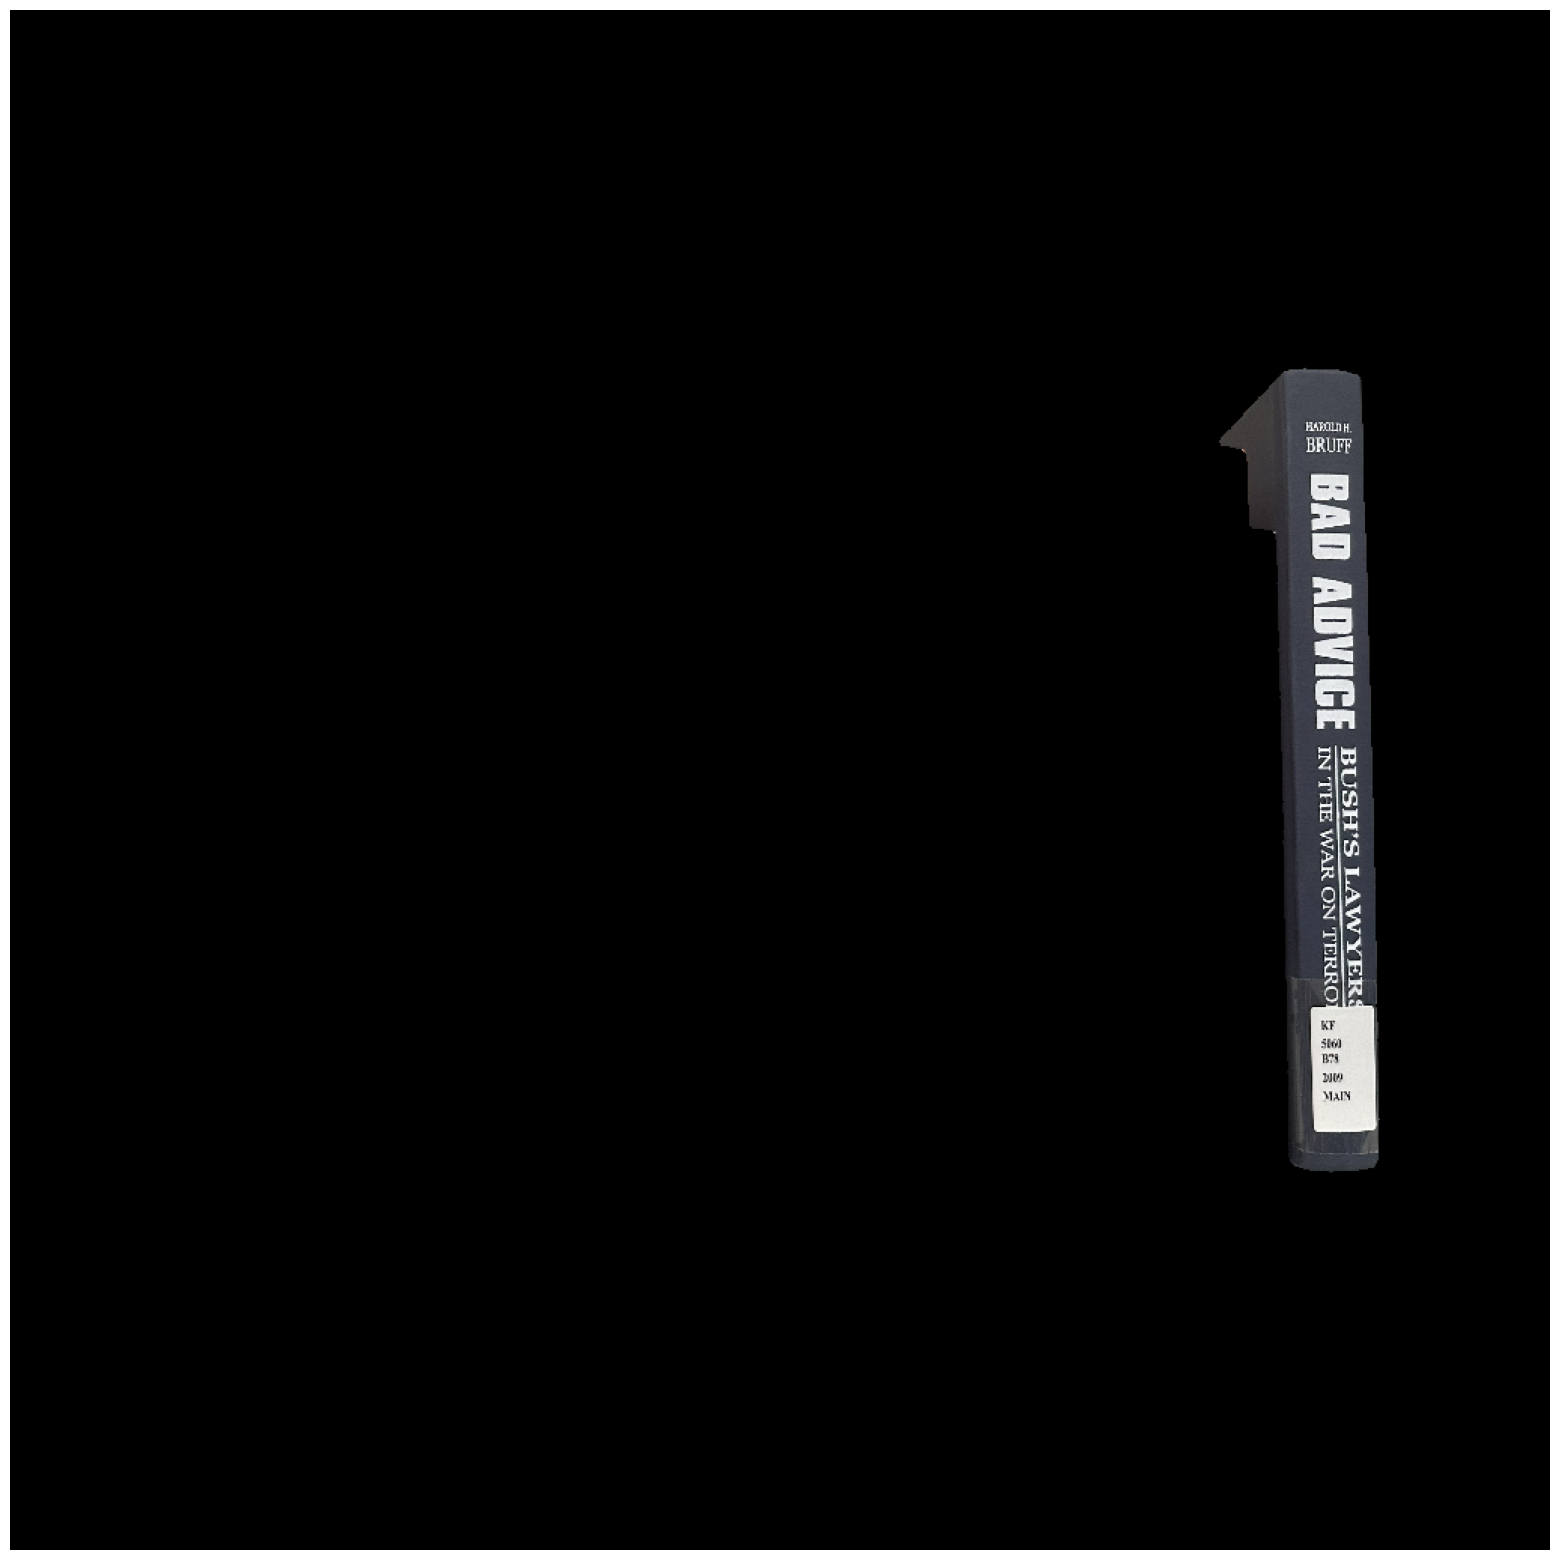

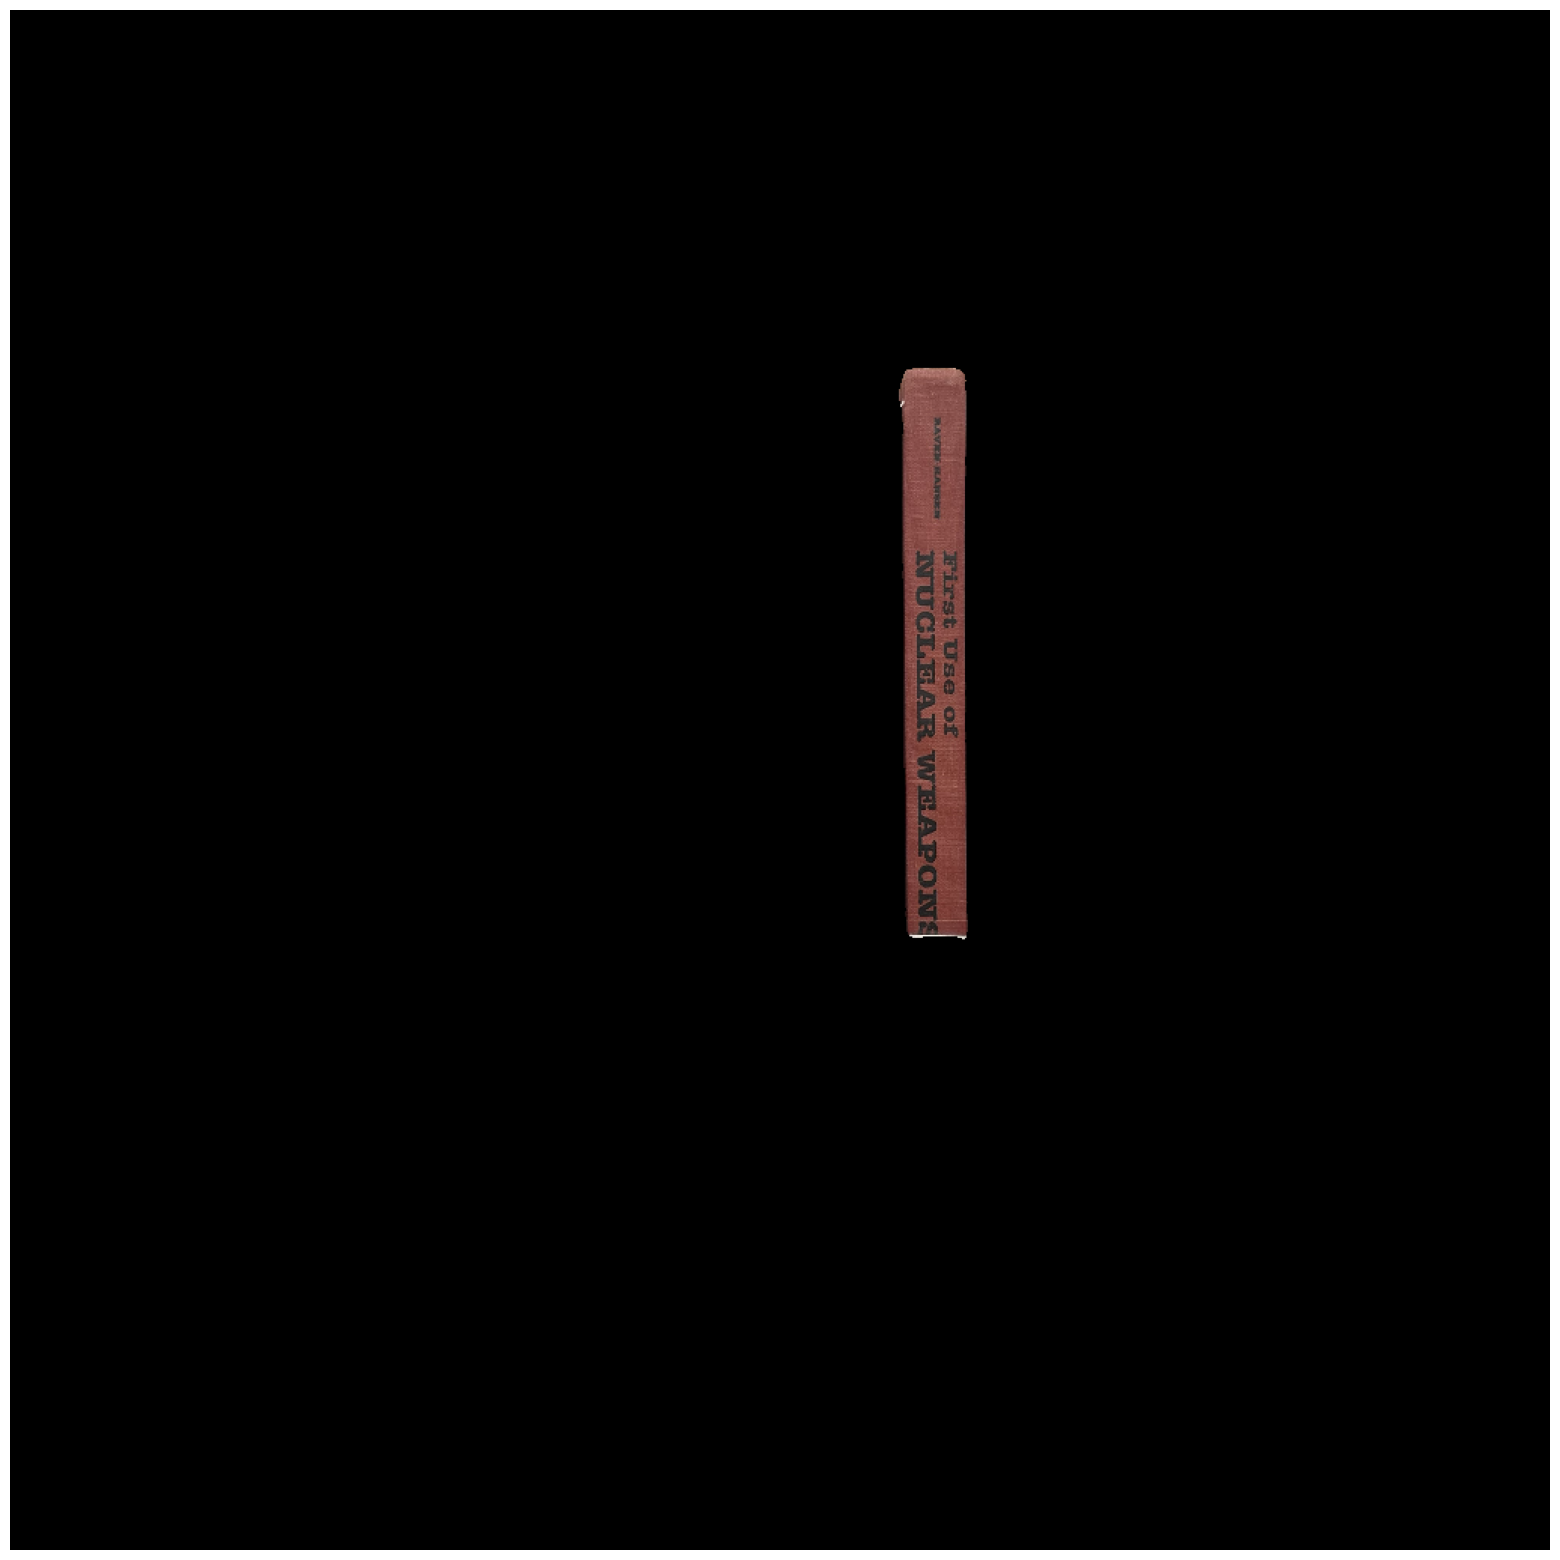

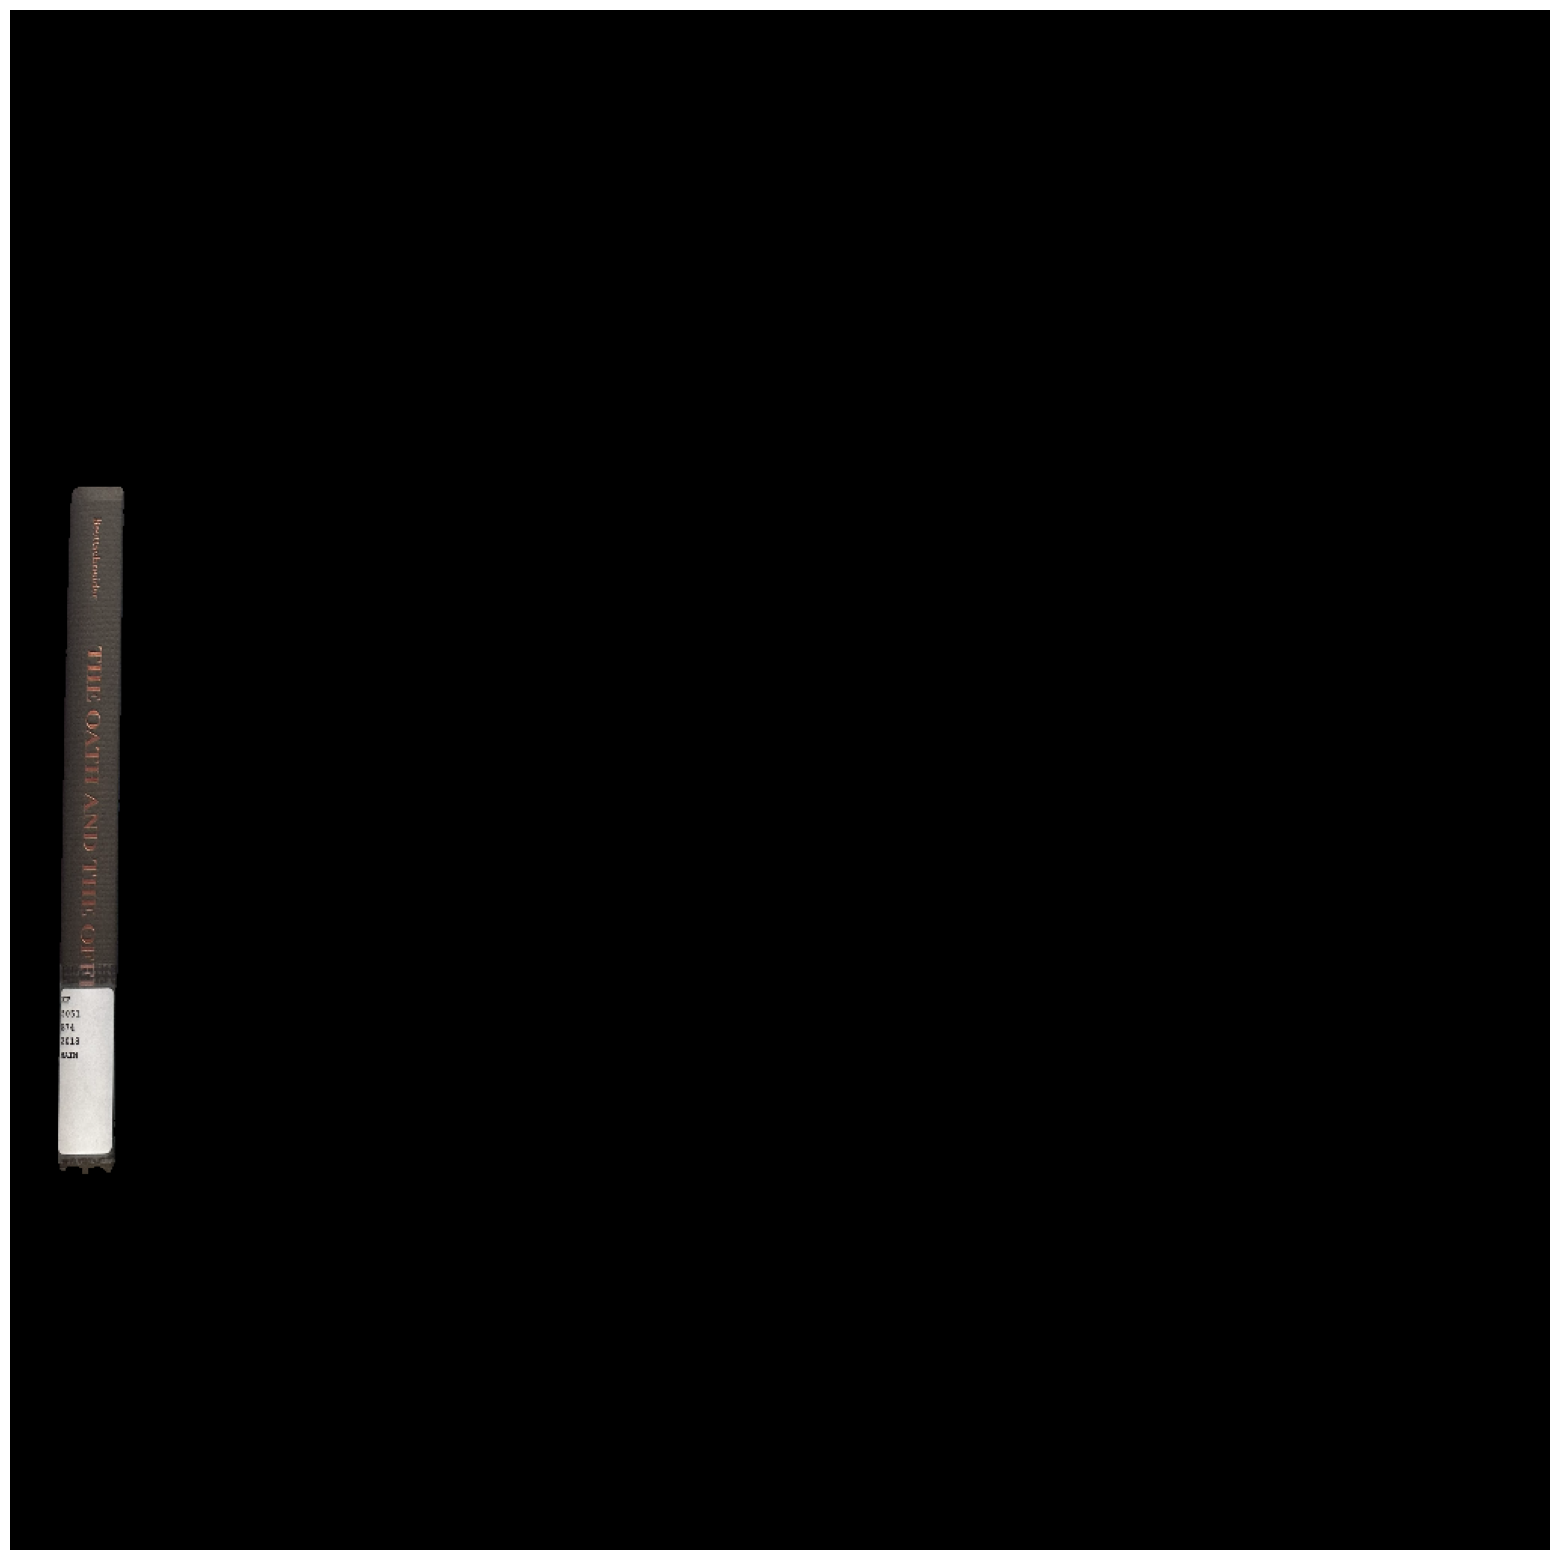

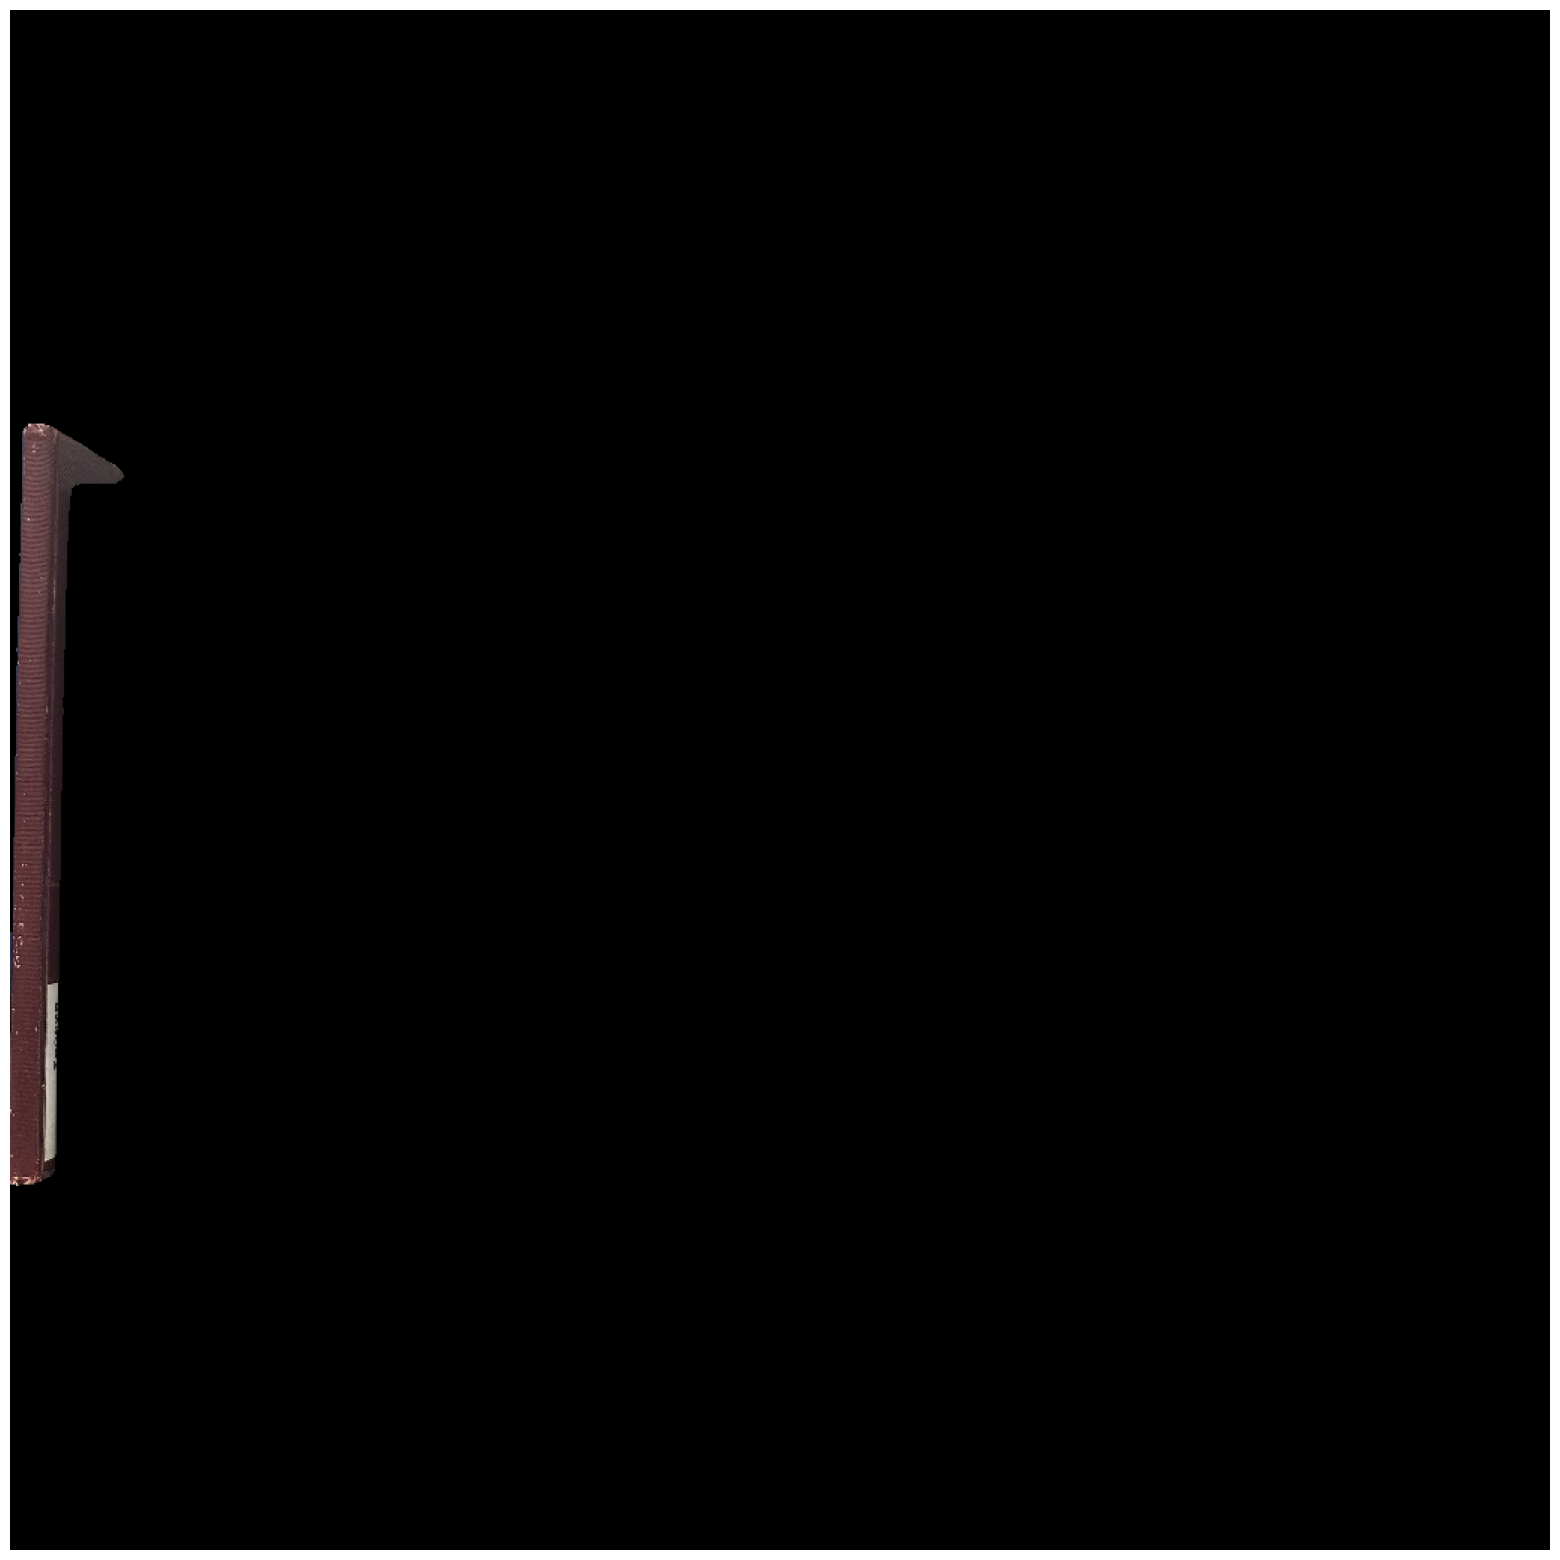

In [15]:
for book in book_segments:
    show_annotated(book["masked_img"])

After running the Google Cloud Vision API to detect a set of pages and their blocks that have text, organize the data into an array of blocks with their corresponding text and coordinates, and then scale the coordinates as needed:

In [16]:
def create_blocks(pages, scaling_x, scaling_y):
    # Iterate through pages and all of their blocks
    blocks = []
    for page in pages:
        for block in page.blocks:
            # Calculate the center of the block
            min_x = min([vertex.x for vertex in block.bounding_box.vertices])
            min_y = min([vertex.y for vertex in block.bounding_box.vertices])
            max_x = max([vertex.x for vertex in block.bounding_box.vertices])
            max_y = max([vertex.y for vertex in block.bounding_box.vertices])
            center_x = min_x + (max_x - min_x) / 2
            center_y = min_y + (max_y - min_y) / 2

            # Iterate through the paragraphs for this block
            paragraphs = []
            for paragraph in block.paragraphs:
                # Iterate through the words for this paragraph
                paragraph_text = ""
                for word in paragraph.words:
                    word_text = "".join([symbol.text for symbol in word.symbols])
                    print("\t\tWord text: {} (confidence: {})".format(word_text, word.confidence))
                    # Iterate through the character symbols for this word
                    for symbol in word.symbols:
                        print("\t\t\tSymbol: {} (confidence: {})".format(symbol.text, symbol.confidence))
                    paragraph_text += word_text + " "
                
                # Remove any non-alphanumeric characters from the paragraph text
                paragraph_text = ''.join(e for e in paragraph_text if e.isalnum() or e.isspace())
                paragraphs.append(paragraph_text[:-1])
                print("\nParagraph text: {}".format(paragraph_text))

            # Create dictionary to store data for this block
            this_block = dict()
            this_block["paragraphs"] = paragraphs
            this_block["center_x"] = int(center_x * scaling_x)
            this_block["center_y"] = int(center_y * scaling_y)
            blocks.append(this_block)
            print("Block text: {}".format(paragraphs))
    return blocks

Detect areas with text from a given image using Google Cloud's Vision API and generate the blocks using the function above:

In [17]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    # Create a BytesIO object and load it with the image content
    with open(path, "rb") as image_file:
        content = image_file.read()
    image_io = io.BytesIO(content)
    image = Image.open(image_io)

    # Get the size of the image
    image_size = image.size
    image = vision.Image(content=content)
    response = client.text_detection(image=image)

    # Open the results from Vision API
    with open("response.json", "w") as f:
        f.write(str(response))
    texts = response.text_annotations

    # Print out all the phrase identified in the image and their locations
    print("Texts:")
    for text in texts:
        print(f'\n"{text.description}"')
        vertices = [f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices]
        print("bounds: {}".format(",".join(vertices)))

    # Iterate through pages and all of their blocks
    pages = response.full_text_annotation.pages
    blocks = create_blocks(pages, 1024 / image_size[0], 1024 / image_size[1])

    # Respond accordingly to an error message
    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )

    return blocks

Print out the result of detecting the text from the original image:

In [18]:
detected_blocks = detect_text(sample_image)
print(detected_blocks)

Texts:

"Mayer
HOWELL
HAROLD H.
BRUFF
Ely
Louis Fisher
PRESIDENTIAL
War and Responsibility
THE CONSTITUTION IN WARTIME
Mark Tu
BAD ADVICE
BONIFAZ
WARRIOR-KING
BUSH'S LAWYERS
IN THE WAR ON TERRO
THE CASE FOR IMPEACHING
AW
Bland
The Black Robe and
The Bald Eagle
PETIM
KF
KF
5060
KEBIH
5060
905
20031
B66
MAIN
5060
KF
E58
C58
1993
KF
2005
MAIN
1996
MAIN
MAIN
5060
B78
2009
MAIN
Dike
THE SUPREME COURT ON EMERGENCY POWERS, FOREIGN AFFAIRS,
AND PROTECTION OF CIVIL LIBERTIES, 1935-1975 Bigel
Howard Ball Bush, the Detainees, and the Constituti
Allan
The Battle over Presidential Power in the War on Terror
INSURRECTION |
KF
5060
B54
1986
MAIN
01
STERN
and
HALPERIN
THE U.S. CONSTITUTION AND
RAVEN-HANSEN
Sheffer
NY
THE POWER TO GO TO WAR
First Use of
NUCLEAR WEAPONS
KF
Congress and United States Foreign Poli
THE JUDICIAL DEVELOPMENT
OF PRESIDENTIAL WAR POWERS
Margolis
KRUTZ
and
PEAKE
K5
A25
1978
MAIN
5
488890
REAULT
5060
A75
F57
KF
KF
5060
5060
A75
1987
MAIN
5057
A68
M37
S53
C66
1987
1985
1999
MAIN


Match the corresponding block for the given text, considering different permutations of the block paragraphs:

In [19]:
def match_text_to_blocks(text, blocks):
    max_similarity = 0
    best_block = None
    for block in blocks:
        permutations = itertools.permutations(block["paragraphs"])
        for permutation in permutations:
            # Calculate the similarity between the text and the block
            perm = ' '.join(list(permutation))
            common_words = len(set(perm.lower().split()).intersection(set(text.lower().split())))
            total_words = len(perm.split())
            if total_words == 0:
                continue
            similarity = common_words / total_words
            
            # Update the maximum similarity and best block if necessary
            if similarity > 0.5 and similarity > max_similarity and total_words >= len(text.split()):
                max_similarity = similarity
                best_block = block
    print(f"Max Similarity for {best_block}: {max_similarity}")
    return best_block

Retrieve the block for a given sample text and display its center:

In [27]:
block = match_text_to_blocks(sample_text, detected_blocks)
print(block)

img = cv2.circle(image.copy(), (block["center_x"], block["center_y"]), 10, (0, 255, 0), -1)
show_annotated(img)

Max Similarity for None: 0
None


TypeError: 'NoneType' object is not subscriptable

With the given coordinates, find the book segment that has the block and display it:

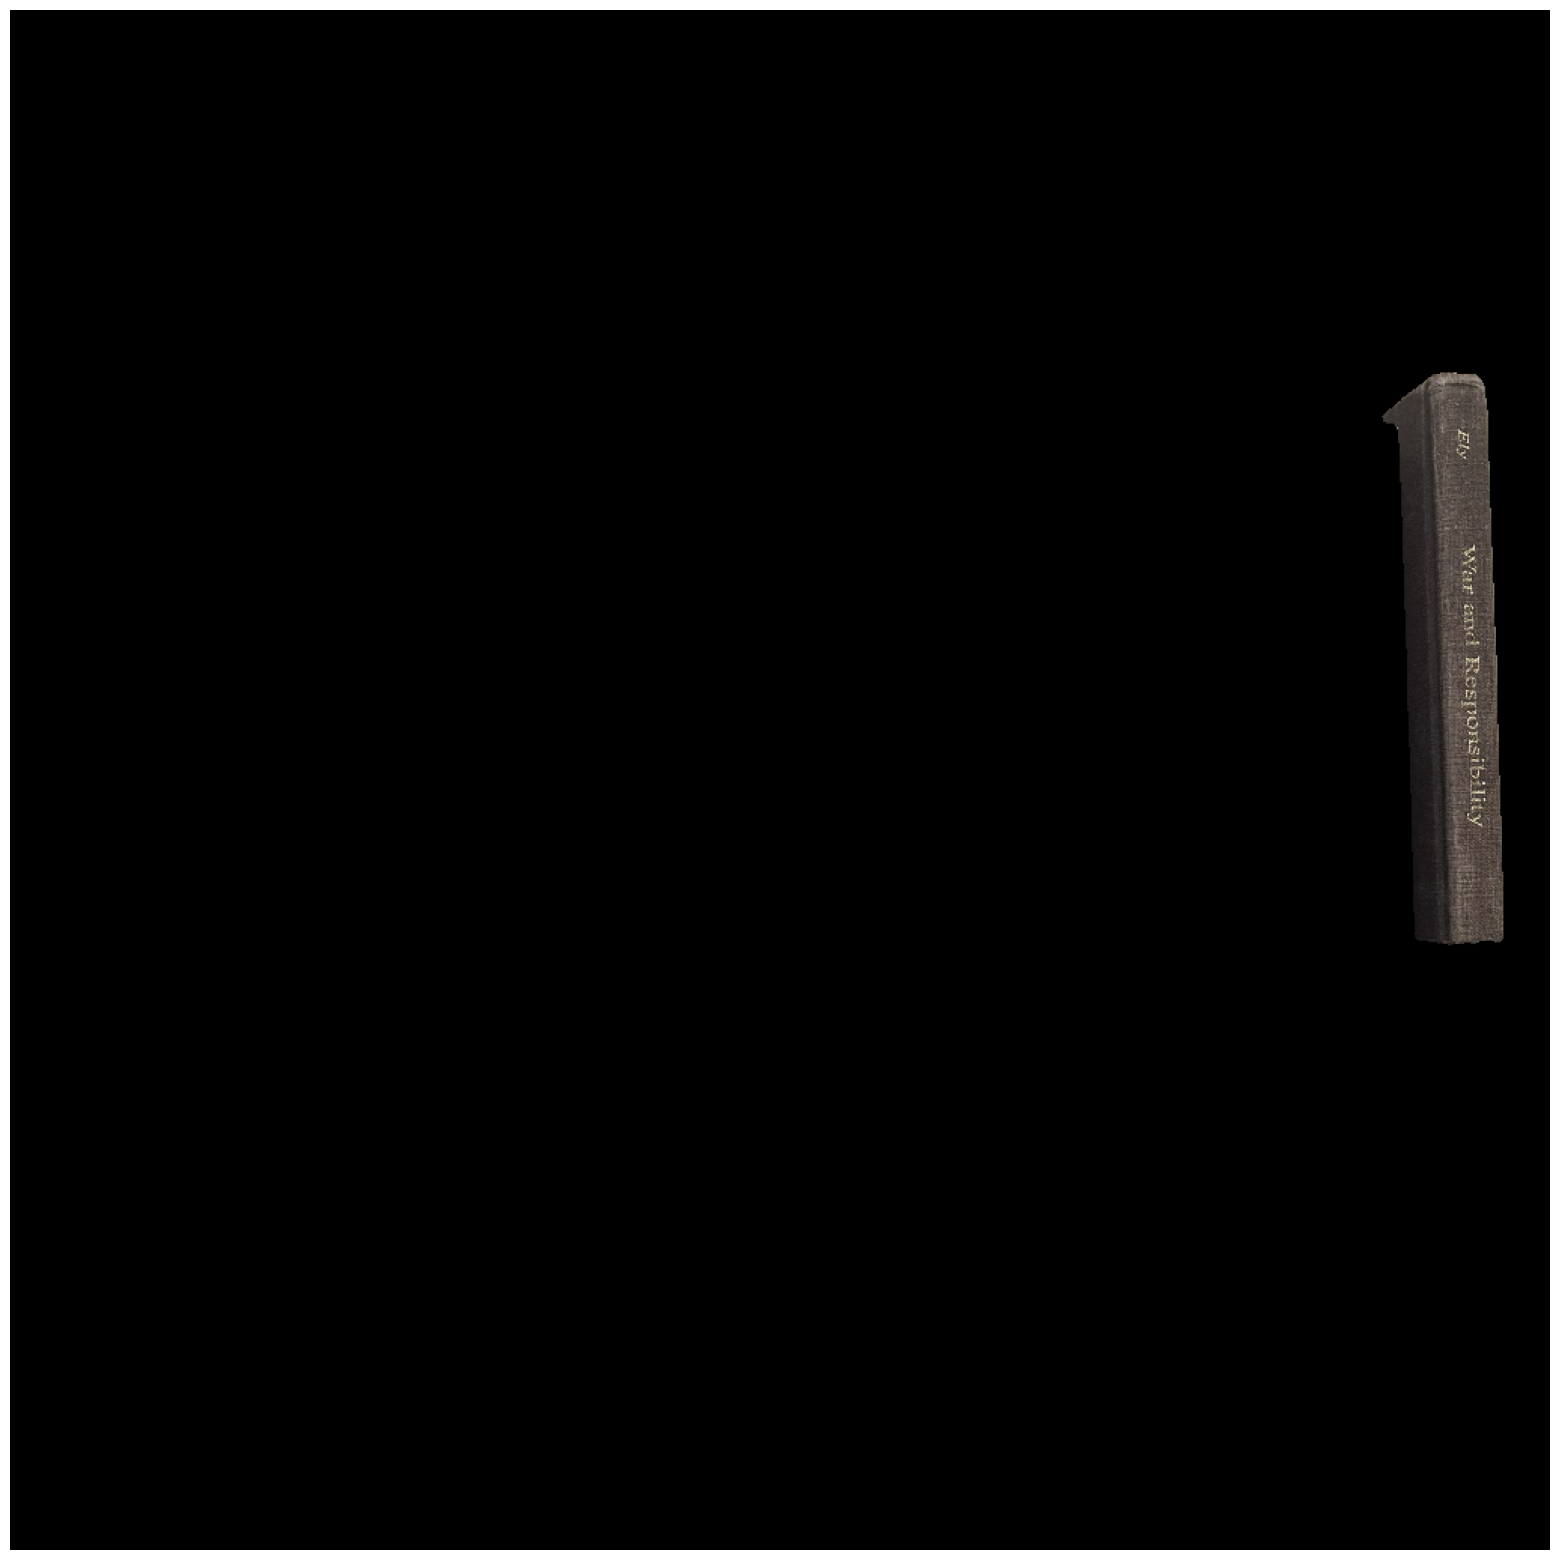

In [23]:
correct_segment = None
for book in book_segments:
    coords = book["coords"]
    masked_img = book["masked_img"]
    for x, y in coords:
        if x == block['center_x'] and y == block['center_y']:
            correct_segment = masked_img
            break
show_annotated(correct_segment)